In [1]:
import pandas as pd
import re
import nltk
import json
import itertools
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import tokenize
from itertools import *
from click import style
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging
import os
import json_lines
import seaborn as sns
tqdm.pandas()


nltk.download('stopwords')
nltk.download('punkt')
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\d067795\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\d067795\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load Data set

In [2]:
with open("C:/Users/d067795/OneDrive - SAP SE/Documents/Master/Masterarbeit/Coding/Corpora/DebatesOrg/debateorg.json", "r") as d:
    debates_dict = json.load(d)
with open("C:/Users/d067795/OneDrive - SAP SE/Documents/Master/Masterarbeit/Coding/Corpora/DebatesOrg/users.json", "r") as u:
      users_dict = json.load(u)

In [3]:
def extract_data(debates_data: dict, users_data: dict) -> pd.DataFrame:
    """Extract and combines debates and user data into a single dataframe. Return the dataframe.
    Currently, only the birthday, education, gender and political orientation are extracted and
    returned as user-defining features.
    Arguments:
    debates_data -- Dictionary containing the debates data.
    users_data -- Dictionary containing the users and their properties.
    """
    extracted_data = []
    properties_of_interest = ["birthday", "ethnicity", "gender", "political_ideology", "education", 
                              "interested", "income", "looking", "party", "relationship", "win_ratio", 
                              "religious_ideology", "number_of_all_debates", "big_issues_dict"]

    for key, debate in tqdm(debates_data.items()):
        # Sometimes, the users of the debate didn't exist anymore at the time
        # the data was collected.
        try:
            category = debate["category"]
        except KeyError:
            category = None
            
        try:
            title = debate["title"]
        except KeyError:
            title = None
        
        try:
            date = debate["start_date"]
        except KeyError:
            date = None
        
        try:
            user1 = users_data[debate["participant_1_name"]]
        except KeyError:
            user1 = None

        try:
            user2 = users_data[debate["participant_2_name"]]
        except KeyError:
            user2 = None

        # If both users do not exist, skip this debate
        if not user1 and not user2:
            logging.debug("Both users are absent from debate data. Skipping.")
            continue

        # For each round in this debate...
        for debate_round in debate["rounds"]:
            # For each argument in this round...
            for argument in debate_round:
                arguing_user = (
                    user1 if argument["side"] == debate["participant_1_position"] else user2)
                
                arguing_user_name = (
                    debate["participant_1_name"] if argument["side"] == debate["participant_1_position"] else debate["participant_2_name"])

                # Skip this argument if arguing user does not exist in the dta
                if not arguing_user:
                    continue
                    
                # Filtering for votes
                votes = []
                for vote in debate['votes']:
                    votes.append(vote['votes_map'][arguing_user_name])

                # Filtering for relevant properties
                properties = {
                    key: value
                    for key, value in arguing_user.items() if key in properties_of_interest}

                # Save the text and find the political ideology of the user.
                extracted_data.append({
                    "argument": argument["text"],
                    "title": title,
                    "category": category,
                    "date": date,
                    **properties,
                    "votes": votes})

    return pd.DataFrame(columns=["argument", "title", "category", "date", *properties_of_interest, "votes"], data=extracted_data)

In [4]:
df_debates = extract_data(debates_dict, users_dict)

100%|█████████████████████████████████████████████████████████████████████████| 78376/78376 [00:06<00:00, 11782.83it/s]


In [9]:
df_debates.iloc[1355]

argument                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [6]:
df_debates['date'] = pd.to_datetime(df_debates['date'] )
df_debates['year'] = df_debates['date'].apply(lambda x: x.year)

In [7]:
df_debates['year'].unique()

array([2009, 2014, 2017, 2007, 2011, 2013, 2008, 2010, 2015, 2012, 2018,
       2016], dtype=int64)

In [56]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

stop_words = set(stopwords.words('english')) 

def preprocessStringToTokens(opinion_string):
    # 1. First Lower Case everything
    opinion_string = opinion_string.lower()

    # 2. Decontract words
    opinion_string = decontracted(opinion_string)

    # 3. Remove numbers
    opinion_string = re.sub(r'\d+', '', opinion_string)

    # 4. Remove URLs
    opinion_string = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', opinion_string)

    # 5. Split into sentences
    opinion_sentences = tokenize.sent_tokenize(opinion_string)

    # 6. Split into tokens and remove punctuation
    wordMap = []
    for s in opinion_sentences:
        s = re.sub(r"[^A-Za-z]+", " ", s)
        wordMap.append(word_tokenize(s))

    return wordMap

def preprocessStringToSentences(opinion_string):
    # 1. First Lower Case everything
    opinion_string = opinion_string.lower()

    # 2. Decontract words
    opinion_string = decontracted(opinion_string)

    # 3. Remove numbers
    opinion_string = re.sub(r'\d+', '', opinion_string)

    # 4. Remove URLs
    opinion_string = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', opinion_string)

    # 5. Split into sentences
    opinion_sentences = tokenize.sent_tokenize(opinion_string)

    # 6. Remove punctuation
    wordMap = []
    for s in opinion_sentences:
        s = re.sub(r"[^A-Za-z]+", " ", s)
        wordMap.append(s)

    return wordMap

def preprocessCommentWithoutTokens(opinion_string):
    # 1. First Lower Case everything
    opinion_string = opinion_string.lower()

    # 2. Decontract words
    opinion_string = decontracted(opinion_string)

    # 3. Remove numbers
    opinion_string = re.sub(r'\d+', '', opinion_string)

    # 4. Remove URLs
    opinion_string = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', opinion_string)  
    
    # 5. Remove special characters
    opinion_string = re.sub(r'[.,\/#!$%\^&\*;:{}=\-_`~()]',' ', opinion_string)
    opinion_string = opinion_string.replace('\n',' ')
    opinion_string = opinion_string.replace('\r',' ')
    
    opinion_string = ' '.join(opinion_string.split())
    tokens = word_tokenize(opinion_string)

    return tokens

In [58]:
df_debates['preprocessedArgTokens'] = df_debates.progress_apply(lambda row: preprocessStringToTokens(row['argument']),axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 510771/510771 [21:32<00:00, 395.30it/s]


In [17]:
df_debates['preprocessedArgSentences'] = df_debates.progress_apply(lambda row: preprocessStringToSentences(row['argument']),axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 510771/510771 [06:30<00:00, 1307.45it/s]


In [57]:
df_debates['preprocessedArg'] = df_debates.progress_apply(lambda row: preprocessCommentWithoutTokens(row['argument']),axis=1)

  6%|████▍                                                                     | 30302/510771 [00:34<09:12, 868.93it/s]


KeyboardInterrupt: 

In [17]:
df_debatesSentence.to_csv('debatesSentence.csv', sep=";")

In [19]:
df_debatesTokens.to_csv('debatesTokens.csv', sep=";")

In [4]:
df_debatesSentence = pd.read_csv('debatesSentence.csv', delimiter=";")

In [10]:
df_debatesSentence['preprocessedArgSentences'][0]

'r'

## TARGET & ATTRIBUTES

In [6]:
winogender = pd.read_csv("C:/Users/d067795/OneDrive - SAP SE/Documents/Master/Masterarbeit/Coding/Corpora/Targets/winogender-schemas-master/data/occupations-stats.tsv",sep='\t')


In [9]:
maleterms = []
femaleterms = []

for index, row in winogender.iterrows():
    if row['bergsma_pct_female'] < 40:
        maleterms.append(row['occupation'])
    if row['bergsma_pct_female'] > 60:
        femaleterms.append(row['occupation'])

#### Gender

In [59]:
# sex- career
def weat_6():
    targets_1 = ["Amy", "Joan", "Lisa", "Sarah", "Diana", "Kate", "Ann", "Donna"]
    targets_2 = ["John", "Paul", "Mike", "Kevin", "Steve", "Greg", "Jeff", "Bill"]
    attributes_1 = ["home", "parents", "children", "family", "cousins", "marriage", "wedding", "relatives"]
    attributes_2 = ["executive", "management", "professional", "corporation", "salary", "office", "business", "career"]

    return targets_1, targets_2, attributes_1, attributes_2

# sex - math
def weat_7():
    targets_1 = ["female", "woman", "girl", "sister", "she", "her", "hers", "daughter"]
    targets_2 = ["male", "man", "boy", "brother", "he", "him", "his", "son"]
    attributes_1 = ["poetry", "art", "dance", "literature", "novel", "symphony", "drama", "sculpture"]
    attributes_2 = ["math", "algebra", "geometry", "calculus", "equations", "computation", "numbers", "addition"]
    return targets_1, targets_2, attributes_1, attributes_2


# sex - science
def weat_8():
    targets_1 = ["sister", "mother", "aunt", "grandmother", "daughter", "she", "hers", "her"]
    targets_2 = ["brother", "father", "uncle", "grandfather", "son", "he", "his", "him"]
    attributes_1 = ["poetry", "art", "Shakespeare", "dance", "literature", "novel", "symphony", "drama"]
    attributes_2 = ["science", "technology", "physics", "chemistry", "einstein", "nasa", "experiment", "astronomy"]
    return targets_1, targets_2, attributes_1, attributes_2


# Multi class word embeddings (Caliskan inspired) 
def naaclGender():
    targets_1 = ["sister", "mother", "aunt", "grandmother", "daughter", "she", "hers", "her"]
    targets_2 = ["brother", "father", "uncle", "grandfather", "son", "he", "his", "him"]   
    attributes_1 = ["secretary", "nurse", "clerk", "artist", "homemaker", "dancer", "singer", "librarian", "maid", 
                    "hairdresser", "stylist", "receptionist", "counselor"]
    attributes_2 = ["manager", "executive", "doctor", "lawyer", "programmer", "scientist", "soldier", "supervisor", 
                    "rancher", "janitor", "firefighter", "officer"]
    return targets_1, targets_2, attributes_1, attributes_2

# RedditBias
def redditBiasGender():
    targets_1 = ["woman", "women", "girl", "mother", "daughter", "wife", "niece", "mom", "bride", "lady", 
                 "madam", "hostess", "female", "aunt", "sister", "she"]
    targets_2 = ["man", "men", "boy", "father", "son", "husband", "nephew", "dad", "groom", "gentleman", 
                 "sir", "host", "male", "uncle", "brother", "he"]   
    attributes_1 = ["nurse", "secretary", "housekeep", "cook", "sewing", "cleaning", "waitress", "maids", "maid", 
                    "childcare", "receptionist", "clerk", "homecare", "poetry", "art", "dance", "literature", "novel", 
                    "symphony", "drama", "sculpture", "shakespeare"]
    attributes_2 = ["surgeon", "executive", "manager", "officer", "engineering", "programming", "lawyer", "engineers", 
                    "engineer", "finance", "administrator", "physician", "science", "math", "science", "geometry", 
                    "technology", "equations", "computation", "physics", "chemistry", "einstein"]
    return targets_1, targets_2, attributes_1, attributes_2
    


# WinoBias (Zhao et.al.)
def winoBias():
    targets_1 = ['actress', 'actresses', 'airwoman', 'airwomen', 'aunt', 'aunts', 'bride', 'brides', 'businesswoman', 
                 'businesswomen', 'chairwoman', 'chairwomen', 'chick', 'chicks', 'daughter', 'daughters', 'female', 
                 'females', 'gal', 'gals', 'girl', 'girls', 'granddaughter', 'granddaughters', 'her', 'herself', 
                 'ladies', 'lady', 'maam', 'mentleman', 'miss', 'mom', 'mommies', 'mommy', 'moms', 'mother', 'mothers',
                 'mrs', 'ms', 'policewoman', 'princess', 'princesses', 'princessesprincess', 'queen', 'queens', 'she',
                 'sister', 'sisters', 'spokeswoman', 'spokeswomen', 'wife', 'wives', 'woman', 'women']
    targets_2 = ["actor", "actors", "airman", "airmen", "uncle", "uncles", "boy", "boys", "groom", "grooms", 
                 "brother", "brothers", "businessman", "businessmen", "chairman", "chairmen", "dude", "dudes", 
                 "dad", "dads", "daddy", "daddies", "son", "sons", "father", "fathers", "male",  "males", "guy", 
                 "guys", "gentleman", "gentlemen", "grandson", "grandsons", "he", "himself", "him", "his", "husband", 
                 "husbands", "king", "kings", "lord", "lords", "sir", "man", "men", "mr", "policeman", "policemen", 
                 "prince", "princes", "spokesman", "spokesmen"]
    attributes_1 = ["attendant", "cashier", "teacher", "nurse", "assistant", "secretary", "auditor", "cleaner", 
                    "receptionist", "clerk", "counselor", "designer", "hairdresser", "writer", "housekeeper", 
                    "baker", "accountant", "editor", "librarian", "tailor"]
    attributes_2 = ["driver", "supervisor", "janitor", "cook", "mover", "laborer", "construction worker", "chief", 
                    "developer", "carpenter", "manager", "lawyer", "farmer", "salesperson", "physician", "guard", 
                    "analyst", "mechanic", "sheriff", "CEO", "doctor"]
    return targets_1, targets_2, attributes_1, attributes_2


#### Ethnicity

In [60]:
# (European / African American) (WEAT-3, WEAT-4, WEAT-5) --> Also changed order

# Here they deleted the infrequent african american names, and the same number randomly choosen from the european american names
def weat_3():
    # excluded: Lerone, Percell, Rasaan, Rashaun, Everol, Terryl, Aiesha, Lashelle, Temeka, Tameisha, Teretha, Latonya, Shanise,
    # Sharise, Tashika, Lashandra, Shavonn, Tawanda,
    targets_1 = ["Alonzo", "Jamel",  "Theo", "Alphonse", "Jerome", "Leroy", "Torrance", "Darnell", "Lamar", "Lionel",
            "Tyree", "Deion", "Lamont", "Malik", "Terrence", "Tyrone",  "Lavon", "Marcellus", "Wardell", "Nichelle",
            "Shereen", "Ebony", "Latisha", "Shaniqua", "Jasmine", "Tanisha", "Tia", "Lakisha", "Latoya",  "Yolanda",
            "Malika",  "Yvette", "Lerone", "Percell", "Rasaan", "Rashaun", "Everol", "Terryl", "Aiesha", "Lashelle",
            "Temeka", "Tameisha", "Teretha", "Latonya", "Shanise", "Sharise", "Tashika", "Lashandra", "Shavonn", "Tawanda"]

    # excluded in the original paper: Chip, Ian, Fred, Jed, Todd, Brandon, Wilbur, Sara, Amber, Crystal, Meredith, Shannon, Donna,
    # Bobbie-Sue, Peggy, Sue-Ellen, Wendy
    targets_2 = ["Adam", "Harry", "Josh", "Roger", "Alan", "Frank", "Justin", "Ryan", "Andrew", "Jack", "Matthew", "Stephen",
                "Brad", "Greg", "Paul", "Hank", "Jonathan", "Peter", "Amanda", "Courtney", "Heather", "Melanie",
                "Katie", "Betsy", "Kristin", "Nancy", "Stephanie", "Ellen", "Lauren",  "Colleen", "Emily", "Megan", "Rachel",
                "Chip", "Ian", "Fred", "Jed", "Todd", "Brandon", "Wilbur", "Sara", "Amber", "Crystal", "Meredith", "Shannon",
                "Donna", "Bobbie-Sue", "Peggy", "Sue-Ellen", "Wendy"]

    # same as before but agony and prison are replaced with bomb and evil
    attributes_1 = ["abuse", "crash", "filth", "murder", "sickness", "accident", "death", "grief", "poison", "stink",
                "assault", "disaster", "hatred", "pollute", "tragedy", "divorce", "jail", "poverty", "ugly", "cancer",
                "kill", "rotten",
                "vomit", "bomb", "evil"]

    attributes_2 = ["caress", "freedom", "health", "love", "peace", "cheer", "friend", "heaven", "loyal", "pleasure",
              "diamond", "gentle", "honest", "lucky", "rainbow", "diploma", "gift", "honor", "miracle", "sunrise",
              "family", "happy", "laughter", "paradise", "vacation"]
    return targets_1, targets_2, attributes_1, attributes_2


# again: african american names vs. european american names and pleasant vs unpleasant but with different names
def weat_4():
    # excluded in GloVe experiments:  Tremayne, Latonya,
    targets_1 = ["Darnell", "Hakim", "Jermaine", "Kareem", "Jamal", "Leroy", "Rasheed", "Tyrone", "Aisha", "Ebony",
                "Keisha", "Kenya",  "Lakisha", "Latoya", "Tamika", "Tanisha", "Tremayne", "Latonya"]

    # excluded as in the original paper: Jay, Kristen, (here only excluded in the glove experiments)
    targets_2 = ["Brad", "Brendan", "Geoffrey", "Greg", "Brett",  "Matthew", "Neil", "Todd", "Allison", "Anne",
                "Carrie", "Emily", "Jill", "Laurie",  "Meredith", "Sarah", "Jay", "Kristen"]

    # same as before but agony and prison are replaced with bomb and evil
    attributes_1 = ["abuse", "crash", "filth", "murder", "sickness", "accident", "death", "grief", "poison", "stink",
                  "assault", "disaster", "hatred", "pollute", "tragedy", "divorce", "jail", "poverty", "ugly",
                  "cancer",
                  "kill", "rotten",
                  "vomit", "bomb", "evil"]

    attributes_2 = ["caress", "freedom", "health", "love", "peace", "cheer", "friend", "heaven", "loyal", "pleasure",
                  "diamond", "gentle", "honest", "lucky", "rainbow", "diploma", "gift", "honor", "miracle", "sunrise",
                  "family", "happy", "laughter", "paradise", "vacation"]

    return targets_1, targets_2, attributes_1, attributes_2


# again african american vs european american names, but with different attributes
def weat_5():
    # excluded in GloVe experiments:  Tremayne, Latonya,
    targets_1 = ["Darnell", "Hakim", "Jermaine", "Kareem", "Jamal", "Leroy", "Rasheed", "Tyrone", "Aisha", "Ebony",
                "Keisha", "Kenya",  "Lakisha", "Latoya", "Tamika", "Tanisha", "Tremayne", "Latonya"]

    # excluded as in the original paper: Jay, Kristen, (here only excluded in the glove experiments)
    targets_2 = ["Brad", "Brendan", "Geoffrey", "Greg", "Brett",  "Matthew", "Neil", "Todd", "Allison", "Anne",
                "Carrie", "Emily", "Jill", "Laurie",  "Meredith", "Sarah", "Jay", "Kristen"]

    attributes_1 = ["agony", "terrible", "horrible", "nasty", "evil", "war", "awful", "failure"]

    attributes_2 = ["joy", "love", "peace", "wonderful", "pleasure", "friend", "laughter", "happy"]

    return targets_1, targets_2, attributes_1, attributes_2


# NAACL -->!!! ÜBERARBEITEN!
def naacl():
    targets_1 = ["black", "africa", "african", "blacks", "africans"]
    targets_2 = ["caucasian", "america", "european", "white", "bible", "priest", "caucasians", "americans", "europeans"]
    attributes_1 = ["slave", "musician", "runner", "criminal", "homeless", "violent", "abuse", "crash", "drug", "dealer", "uncivilized"]
    attributes_2 = ["manager", "executive", "redneck", "hillbilly", "farmer", "leader", "disciplined", "peaceful", "pure", "clean", "pleasant", "nice"]
    return targets_1, targets_2, attributes_1, attributes_2


# RedditBias
def redditBiasEthnicity():
    targets_1 = ["black", "african american", "african", "afro", "afroamericans", "negroes", "dark skin"]
    targets_2 = ["white", "anglo american", "american", "anglo", "angloamericans", "caucasians", "light skin"]   
    attributes_1 = ["violent", "abuse", "crash", "filth", "murder", "sickness", "accident", "death", "grief", "poison", 
                    "stink", "assault", "disaster", "hatred", "pollute", "tragedy", "divorce", "jail", "poverty", 
                    "ugly", "kill", "rotten", "vomit", "agony", "prison", "terrible", "horrible", "nasty", "evil",
                    "war", "awful", "failure", "slave", "criminal", "homeless", "underclass", "drug dealer", 
                    "uncivilized", "aggressive", "oversexed", "crack addict", "animalistic", "dangerous", 
                    "less intelligent", "predator", "unclean", "loud", "drug addict", "lazy", "backward", "bossy",
                    "headstrong", "hyper", "sexual"]
    attributes_2 = ["peaceful", "honour", "pure", "clean", "defend", "health", "fortune", "creation", "joy", "healthy",
                    "fragrance", "protect", "success", "love", "clean", "fortune", "loyal", "university", "wealth",
                    "beautiful", "save", "brilliant", "comfort", "relief", "university", "awesome", "pleasant", "nice",
                    "virtuous", "peace", "charming", "success", "administrator", "police", "prosperous", "privileged", 
                    "police", "civilized", "friendly", "moral", "disciplined", "noble", "innocent", "intelligent", 
                    "protector", "clean", "quiet", "police", "active", "advanced", "submissive", "obedient", "decent"]
    return targets_1, targets_2, attributes_1, attributes_2

#### Religion

In [61]:
# NAACL
def religiousTermsJews():
    targets_1 = ["judaism", "jew", "jews", "synagogue", "rabbi", "jewish"]
    targets_2 = ["christianity", "christian", "christians", "church", "bible", "priest"]
    attributes_1 = ["greedy", "cheap", "hairy", "liberal", "greed", "meek", "nerdy", "nerd", "hook-nose", "violin"]
    attributes_2 = ["judgemental", "conservative", "familial", "generous", "generosity", "confident", "disciplined", "spiritual"]
    return targets_1, targets_2, attributes_1, attributes_2


def religiousTermsMuslims():
    targets_1 = ["islam", "muslim", "muslims", "mosque", "quran", "imam"]
    targets_2 = ["christianity", "christian", "christians", "church", "bible", "priest"]
    attributes_1 = ["terrorist", "violent", "dirty", "uneducated", "threat", "dangerous", "criminal"]
    attributes_2 = ["nonviolence", "safety", "lawful", "defend", "friendly", "friend", "peaceful", "clean"]
    return targets_1, targets_2, attributes_1, attributes_2

# RedditBias
def redditBiasReligionJews():
    targets_1 = ["jew", "jews", "judaism", "jewish", "synagogue"]
    targets_2 = ["christian", "christians", "christianity", "church"]   
    attributes_1 = ["greed", "meek", "nerd", "circumcision", "violin", "spoiled", "materialistic", "hook nose", 
                    "hooked nose", "beady eyes", "large nose", "red hair", "red hair", "money lending", "greedy", 
                    "miserly", "miser", "shady practices", "frugal", "thrift", "lust", "overprotective", "loud", 
                    "talkative", "overfeed", "caretak", "guilt inducement", "aggressive", "pushy", "immigrant", 
                    "immigration", "dominating", "overbearing", "interfering", "selfish", "spoiled brats", 
                    "sexually repressive", "jewface", "long beard", "evil", "devil", "satan", "inferior", "horn", 
                    "hoof", "tail", "manipulative", "philanthropist", "cannibal", "insatiable", "effeminate", "conspiring"]
    attributes_2 = ["generosity", "confident", "dummy", "decircumcision", "disciplined", "spiritual", "short nose", 
                    "blue eyes", "short nose", "black hair", "blackhair", "money borrowing", "generous", "spendthrift", 
                    "reputable practices", "extravagant", "lavishness", "apathy", "careless", "quiet", "untalkative", 
                    "underfeed", "peaceful", "modest", "emigrate", "emigration", "submissive", "humble", "unobtrusive", 
                    "selfless", "obedient child", "good", "angel", "god", "superior", "no horn", "no tail", "innocent", 
                    "civilized", "appeasable", "masculine", "neglecting"]
    return targets_1, targets_2, attributes_1, attributes_2


# RedditBias
def redditBiasReligionMuslims():
    targets_1 = ["muslim", "muslims", "islam", "islamic", "islamism", "arab", "arabs"]
    targets_2 = ["christian", "christians", "christianity", "church", "bible", "priest"]   
    attributes_1 = ["terrorist", "terrorism", "threat", "threaten", "dangerous", "deadly", "attack", "bomb", "murder", 
                    "hijack", "criminal", "enemy", "war", "enemies", "extremist", "radical", "hate", "rich", "lazy", 
                    "flashy", "lazy sheik", "oil sheik", "rapist", "slaves", "shooter", "belly dancers", "hijab", 
                    "viel", "vielded", "oppressed", "patriarchy", "misogyny", "patriarchal", "deport", "detain",
                    "thieves", "thug", "charlatan", "brute", "power hungry", "beard", "wealthy oilmen", 
                    "harem maiden", "suicide bomb", "headscarves", "violence", "violent", "hostile", "sinister"]
    attributes_2 = ["police", "nonviolence", "safety", "defend", "helpful", "safe", "defend", "build", "restore", 
                    "relinquish", "lawful", "friend", "peace", "friends", "moderate", "conservative", "love", "poor",
                    "energetic", "simple", "defender", "freemen", "hero", "hat", "unviel", "unvielded", "rejoiced", 
                    "matriarchy", "philogyny", "matriarchal", "admit", "liberate", "police", "hero", "honest", "mild",
                    "gratified", "clean shave", "negotiator", "compassion", "gentle", "kind", "happy"]
    return targets_1, targets_2, attributes_1, attributes_2


#### Sexual Orientation

In [62]:
def sexualTerms():
    targets_1 = ["gays", "lesbians", "homosexual", "bisexual", "queer", "imam", "homosexuals", "bisexual", "queers", "gay", "transgender"]
    targets_2 = ["heterosexual", "straights", "heterosexuals", "monosexual", "monosexuals", "straight"]
    attributes_1 = ["mentally", "ill", "flamboyant", "pedophile", "sin", "promiscuous", "unnormal", "immoral", "unethical", "wrong"]
    attributes_2 = ["mentally", "strong", "modest", "normal", "moral", "clean", "true", "right"]
    return targets_1, targets_2, attributes_1, attributes_2

# RedditBias
def redditBiasSexualOr():
    targets_1 = ["gay", "gays", "lesbian", "lesbians", "bisexual", "bisexuals", "homosexual", "homosexuals",
                "transgender", "transgenders", "sapphic", "pansexual", "queer", "queers", "genderqueer", "transsexual",
                 "transsexuals", "crosssexual", "crosssexuals", "unisexual", "unisexuals", "epicene", "epicenes",
                "LGBT", "LGBTQ"]
    targets_2 = ["straight", "straights", "monosexual", "monosexuals", "heterosexual", "heterosexuals", "cisgender",
                "cisgenders", "sexually normal", "hetero", "heteros"]   
    attributes_1 = ["mentally ill", "polygamous", "flamboyant", "pedophile", "sexual predator", "mental disorder",
                    "irreligious", "villain", "serial killer", "depress", "adultery", "drug addict", "sadist", "arts",
                    "artistic", "theatre", "dramatic", "show queen", "fashion", "predator", "party drugs", 
                    "illicit drugs", "alcohol", "sexual abuse", "child rapist", "indecisi", "promiscuous", 
                    "sexually manipulative", "prostitute", "drag queen", "drag king", "criminal", "hypersexual", 
                    "asexual", "pervert", "poofter", "faggot", "fag", "weak", "timid", "loser", "loner", "lonely", 
                    "sin", "disease", "confuse", "queer", "strange", "weird", "coward", "sexually abnormal", "immoral",
                    "insecure", "repulsive", "frustrat", "sinful", "sensitive", "weak minded", "lack self control",
                    "oversex", "submissive", "emotional"]
    attributes_2 = ["mentally", "strong", "monogamous", "modest", "teleiophile", "protector", "mental stability",
                    "hero", "police officer", "cheerful", "healthy", "compassionate", "scientific", "science", "subtle",
                    "unfashion", "defender", "determined", "moral", "chaste", "cisgender", "lawful", "decent", "saint", 
                    "faggot", "strong", "daring", "winner", "cheerful", "virtue", "health", "assured", "normal", 
                    "normal", "brave", "moral", "confident", "delightful", "satisfied", "innocent", "tough", 
                    "dominating", "unemotional"]
    return targets_1, targets_2, attributes_1, attributes_2

#### Disability / Disease

In [63]:
# desease - uncontrollability
def weat_9():
    targets_1 = ["sick", "illness", "influenza", "disease", "virus", "cancer"]
    targets_2 = ["sad", "hopeless", "gloomy", "tearful", "miserable", "depressed"]
    # in w2v experiments, the've replaced short-term with short
    attributes_1 = ["stable", "always", "constant", "persistent", "chronic", "prolonged", "forever"]  
    attributes_2 = ["impermanent", "unstable", "variable", "fleeting", "short-term", "brief", "occasional"]

    return targets_1, targets_2, attributes_1, attributes_2

# disability vs healthy
def disease_healthy():
    targets_1 = ["epilepsy", "deaf", "blind", "wheelchair", "schizophrenia", "paraplegia", "paraplegic", "quadriplegia", "chronical", "illness", "cognitive", "down", "syndrome", "mongoloid", "disability", 
                "invalid", "mental", "mentally", "cerebral", "mute", "disabled", "epileptic", "retarded", "dyslexia", "disorder"]
    targets_2 = ["without", "normal", "healthy"]
    attributes_1 = ["dumb", "cripple", "problem", "homeless", "drug", "alcohol", "ugly", "gun", "guns", "drugs", "addicts", "addict", "disgusting"]
    attributes_2 = ["smart", "lawful", "strong", "normal", "life"]

    return targets_1, targets_2, attributes_1, attributes_2

## Sliding window bias

In [65]:
def get_windows(words, window_size):
    i = 0
    while i < len(words):
        center_word = words[i]
        # Calculate context words
        if ((i-window_size) < 0):
            first_word_index = 0
        else:
            first_word_index = (i-window_size)
        if (i + window_size) < (len(words)):
            last_word_index = i + window_size
        else:
            last_word_index = len(words)
        context_words = words[first_word_index:i] + words[(i+1):last_word_index+1]
        yield center_word, context_words
        i += 1

In [66]:
# Create Cartesian product
def cartesianProductList(list1, list2):
    cartesianProductList = []
    for element in itertools.product(list1, list2):
        cartesianProductList.append(element)
    return cartesianProductList

# Count occurrences
def countOccurrence(comment, targetWordList):
    totalCount = 0
    for sentence in comment: 
        for e in targetWordList:
            temp = sentence.count(e)
            totalCount = totalCount + temp
    return totalCount

# Check whether tuple in sentence
def findBias(comment, cartesianProductList):
    biasedSentences = []
    foundTuples = []
    for sentence in comment:
        for tup in cartesianProductList:
            if tup[0] in sentence and tup[1] in sentence:
                biasedSentences.append(sentence)
                foundTuples.append(tup)
    return pd.Series([biasedSentences, foundTuples, len(foundTuples)])

# Check whether context word is target word and whether attribute is in context
def findBiasInSlidingWindow(comment, t_list, a_list):
    biasedSentences = []
    foundTuples = []
    for sentence in comment:
        for center_word, context_words in get_windows(sentence, 5):
            if center_word in t_list:
                for e in a_list:
                    if e in context_words:
                        biasedSentences.append(sentence)
                        foundTuples.append(tuple([e, center_word]))
    return pd.Series([biasedSentences, foundTuples, len(foundTuples)])

# Check whether tuple in sentence
def findBiasCount(comment, cartesianProductList):
    foundTuples = []
    for sentence in comment:
        for tup in cartesianProductList:
            if tup[0] in sentence and tup[1] in sentence:
                foundTuples.append(tup)
    return len(foundTuples)

def calculateSummarySlidingWindow(dataSet, targetTermFunction):
    t1, t2, a1, a2 = targetTermFunction()
    t1 = [x.lower() for x in t1]
    t2 = [x.lower() for x in t2]
    a1 = [x.lower() for x in a1]
    a2 = [x.lower() for x in a2]
    df = dataSet.copy()

    # Count word occurrences
    df['minorityCount'] =  df.progress_apply(lambda row: countOccurrence(row['preprocessedArgTokens'], t1),axis=1)
    df['majorityCount'] =  df.progress_apply(lambda row: countOccurrence(row['preprocessedArgTokens'], t2),axis=1)

    totalMinorityOccurrence = df['minorityCount'].sum() 
    totalMajorityOccurrence = df['majorityCount'].sum() 

    df[['T1 x A1 Sentences', 'T1 x A1 Tuples Found', 'T1 x A1 Count']] = df.progress_apply(lambda row: findBiasInSlidingWindow(row['preprocessedArgTokens'], t1, a1),axis=1)
    df[['T1 x A2 Sentences', 'T1 x A2 Tuples Found', 'T1 x A2 Count']] = df.progress_apply(lambda row: findBiasInSlidingWindow(row['preprocessedArgTokens'], t1, a2),axis=1)
    df[['T2 x A1 Sentences', 'T2 x A1 Tuples Found', 'T2 x A1 Count']] = df.progress_apply(lambda row: findBiasInSlidingWindow(row['preprocessedArgTokens'], t2, a1),axis=1)
    df[['T2 x A2 Sentences', 'T2 x A2 Tuples Found', 'T2 x A2 Count']] = df.progress_apply(lambda row: findBiasInSlidingWindow(row['preprocessedArgTokens'], t2, a2),axis=1)

    t1_a1_total = df['T1 x A1 Count'].sum() 
    if (t1_a1_total > 0):
        t1_a1_percentage = (t1_a1_total / totalMinorityOccurrence) * 100
        t1_a1_percentage = round(t1_a1_percentage, 2)
    else:
        t1_a1_percentage = 0

    t1_a2_total = df['T1 x A2 Count'].sum() 
    if (t1_a2_total > 0):
        t1_a2_percentage = (t1_a2_total / totalMinorityOccurrence) * 100
        t1_a2_percentage = round(t1_a2_percentage, 2)
    else:
        t1_a2_percentage = 0

    t2_a1_total = df['T2 x A1 Count'].sum() 
    if (t2_a1_total > 0):
        t2_a1_percentage = (t2_a1_total / totalMajorityOccurrence) * 100
        t2_a1_percentage = round(t2_a1_percentage, 2)
    else: 
        t2_a1_percentage = 0

    t2_a2_total = df['T2 x A2 Count'].sum() 
    if (t2_a2_total > 0):
        t2_a2_percentage = (t2_a2_total / totalMajorityOccurrence) * 100
        t2_a2_percentage = round(t2_a2_percentage, 2)
    else:
        t2_a2_percentage = 0

    return pd.Series([totalMinorityOccurrence, totalMajorityOccurrence, t1_a1_total, t1_a1_percentage, t1_a2_total, t1_a2_percentage, t2_a1_total, t2_a1_percentage, t2_a2_total, t2_a2_percentage]), df



In [67]:
# Gender
weat_6_outcome_SW, df_debate_weat_6_SW = calculateSummarySlidingWindow(df_debates, weat_6)

weat_7_outcome_SW, df_debate_weat_7_SW = calculateSummarySlidingWindow(df_debates, weat_7)

weat_8_outcome_SW, df_debate_weat_8_SW = calculateSummarySlidingWindow(df_debates, weat_8)

100%|████████████████████████████████████████████████████████████████████████| 510771/510771 [07:22<00:00, 1154.24it/s]


In [69]:
weat_6_outcome_SW

0     2528.00
1    45497.00
2       33.00
3        1.31
4       17.00
5        0.67
6      262.00
7        0.58
8      143.00
9        0.31
dtype: float64

In [73]:
winoBias_outcome, df_debate_winoBias = calculateSummarySlidingWindow(df_debates, winoBias)

naaclGender_outcome, df_debate_naaclGender = calculateSummarySlidingWindow(df_debates, naaclGender)

redditBiasGender_outcome, df_debate_redditBiasGender = calculateSummarySlidingWindow(df_debates, redditBiasGender)

100%|█████████████████████████████████████████████████████████████████████████| 510771/510771 [10:15<00:00, 830.44it/s]


In [75]:
# Ethnicity
weat_3_outcome_SW, df_debate_weat_3_SW = calculateSummarySlidingWindow(df_debates, weat_3)

weat_4_outcome_SW, df_debate_weat_4_SW = calculateSummarySlidingWindow(df_debates, weat_4)

weat_5_outcome_SW, df_debate_weat_5_SW = calculateSummarySlidingWindow(df_debates, weat_5)

naacl_outcome_SW, df_debate_naacl_SW = calculateSummarySlidingWindow(df_debates, naacl)

redditBiasEthnicity_outcome_SW, df_debate_redditBiasEthnicity_SW = calculateSummarySlidingWindow(df_debates, redditBiasEthnicity)

100%|█████████████████████████████████████████████████████████████████████████| 510771/510771 [10:03<00:00, 845.94it/s]


In [70]:
# Sexual Terms
sexualTerms_outcome, df_debate_sexualTerms = calculateSummarySlidingWindow(df_debates, sexualTerms)

redditBiasSexualOr_outcome, df_debate_redditBiasSexualOr = calculateSummarySlidingWindow(df_debates, redditBiasSexualOr)

100%|█████████████████████████████████████████████████████████████████████████| 510771/510771 [09:33<00:00, 890.50it/s]


In [72]:
redditBiasSexualOr_outcome

0    73934.00
1    17114.00
2     1364.00
3        1.84
4     1653.00
5        2.24
6      148.00
7        0.86
8      314.00
9        1.83
dtype: float64

### Calculate bias

#### Useful functions

In [243]:
# Create Cartesian product
def cartesianProductList(list1, list2):
    cartesianProductList = []
    for element in itertools.product(list1, list2):
        cartesianProductList.append(element)
    return cartesianProductList

# Count occurrences
def countOccurrence(comment, targetWordList):
    totalCount = 0
    for sentence in comment: 
        for e in targetWordList:
            temp = sentence.count(e)
            totalCount = totalCount + temp
    return totalCount

# Check whether tuple in sentence
def findBias(comment, cartesianProductList):
    biasedSentences = []
    foundTuples = []
    for sentence in comment:
        for tup in cartesianProductList:
            if tup[0] in sentence and tup[1] in sentence:
                biasedSentences.append(sentence)
                foundTuples.append(tup)
    return pd.Series([biasedSentences, foundTuples, len(foundTuples)])

# Check whether tuple in sentence
def findBiasCount(comment, cartesianProductList):
    foundTuples = []
    for sentence in comment:
        for tup in cartesianProductList:
            if tup[0] in sentence and tup[1] in sentence:
                foundTuples.append(tup)
    return len(foundTuples)

def calculateSummary(dataSet, targetTermFunction):
    t1, t2, a1, a2 = targetTermFunction()
    t1 = [x.lower() for x in t1]
    t2 = [x.lower() for x in t2]
    a1 = [x.lower() for x in a1]
    a2 = [x.lower() for x in a2]
    df = dataSet.copy()

    # Count word occurrences
    df['minorityCount'] =  df.progress_apply(lambda row: countOccurrence(row['preprocessedArgTokens'], t1),axis=1)
    df['majorityCount'] =  df.progress_apply(lambda row: countOccurrence(row['preprocessedArgTokens'], t2),axis=1)

    totalMinorityOccurrence = df['minorityCount'].sum() 
    totalMajorityOccurrence = df['majorityCount'].sum() 

    # Get biased statistics
    T1_A1_cartesianProduct = cartesianProductList(t1, a1)
    T1_A2_cartesianProduct = cartesianProductList(t1, a2)
    T2_A1_cartesianProduct = cartesianProductList(t2, a1)
    T2_A2_cartesianProduct = cartesianProductList(t2, a2)

    df[['T1 x A1 Sentences', 'T1 x A1 Tuples Found', 'T1 x A1 Count']] = df.progress_apply(lambda row: findBias(row['preprocessedArgTokens'], T1_A1_cartesianProduct),axis=1)
    df[['T1 x A2 Sentences', 'T1 x A2 Tuples Found', 'T1 x A2 Count']] = df.progress_apply(lambda row: findBias(row['preprocessedArgTokens'], T1_A2_cartesianProduct),axis=1)
    df[['T2 x A1 Sentences', 'T2 x A1 Tuples Found', 'T2 x A1 Count']] = df.progress_apply(lambda row: findBias(row['preprocessedArgTokens'], T2_A1_cartesianProduct),axis=1)
    df[['T2 x A2 Sentences', 'T2 x A2 Tuples Found', 'T2 x A2 Count']] = df.progress_apply(lambda row: findBias(row['preprocessedArgTokens'], T2_A2_cartesianProduct),axis=1)

    t1_a1_total = df['T1 x A1 Count'].sum() 
    if (t1_a1_total > 0):
        t1_a1_percentage = (t1_a1_total / totalMinorityOccurrence) * 100
        t1_a1_percentage = round(t1_a1_percentage, 2)
    else:
        t1_a1_percentage = 0

    t1_a2_total = df['T1 x A2 Count'].sum() 
    if (t1_a2_total > 0):
        t1_a2_percentage = (t1_a2_total / totalMinorityOccurrence) * 100
        t1_a2_percentage = round(t1_a2_percentage, 2)
    else:
        t1_a2_percentage = 0

    t2_a1_total = df['T2 x A1 Count'].sum() 
    if (t2_a1_total > 0):
        t2_a1_percentage = (t2_a1_total / totalMajorityOccurrence) * 100
        t2_a1_percentage = round(t2_a1_percentage, 2)
    else: 
        t2_a1_percentage = 0

    t2_a2_total = df['T2 x A2 Count'].sum() 
    if (t2_a2_total > 0):
        t2_a2_percentage = (t2_a2_total / totalMajorityOccurrence) * 100
        t2_a2_percentage = round(t2_a2_percentage, 2)
    else:
        t2_a2_percentage = 0

    return pd.Series([totalMinorityOccurrence, totalMajorityOccurrence, t1_a1_total, t1_a1_percentage, t1_a2_total, t1_a2_percentage, t2_a1_total, t2_a1_percentage, t2_a2_total, t2_a2_percentage]), df



#### Check for word in sentence

In [148]:
# Create Cartesian product
def cartesianProductList(list1, list2):
    cartesianProductList = []
    for element in itertools.product(list1, list2):
        cartesianProductList.append(element)
    return cartesianProductList

# Count occurrences
def countOccurrenceSentence(comment, targetWordList):
    totalCount = 0
    for sentence in comment: 
        words = sentence.split()
        for e in targetWordList:
            temp = words.count(e)
            totalCount = totalCount + temp
    return totalCount

# Check whether tuple in sentence
def findBiasSentence(comment, cartesianProductList):
    biasedSentences = []
    foundTuples = []
    for sentence in comment:
        for tup in cartesianProductList:
            if contains_word(sentence, tup[0]) and contains_word(sentence, tup[1]):
                biasedSentences.append(sentence)
                foundTuples.append(tup)
    return pd.Series([biasedSentences, foundTuples, len(foundTuples)])

# Check whether tuple in sentence
def findBiasCount(comment, cartesianProductList):
    foundTuples = []
    for sentence in comment:
        for tup in cartesianProductList:
            if tup[0] in sentence and tup[1] in sentence:
                foundTuples.append(tup)
    return len(foundTuples)

def contains_word(s, w):
    return (' ' + w + ' ') in (' ' + s + ' ')



def calculateSummarySentences(dataSet, targetTermFunction):
    t1, t2, a1, a2 = targetTermFunction()
    t1 = [x.lower() for x in t1]
    t2 = [x.lower() for x in t2]
    a1 = [x.lower() for x in a1]
    a2 = [x.lower() for x in a2]
    df = dataSet.copy()

    # Count word occurrences
    df['minorityCount'] =  df.apply(lambda row: countOccurrenceSentence(row['preprocessedArgSentences'], t1),axis=1)
    df['majorityCount'] =  df.apply(lambda row: countOccurrenceSentence(row['preprocessedArgSentences'], t2),axis=1)

    totalMinorityOccurrence = df['minorityCount'].sum() 
    totalMajorityOccurrence = df['majorityCount'].sum() 

    # Get biased statistics
    T1_A1_cartesianProduct = cartesianProductList(t1, a1)
    T1_A2_cartesianProduct = cartesianProductList(t1, a2)
    T2_A1_cartesianProduct = cartesianProductList(t2, a1)
    T2_A2_cartesianProduct = cartesianProductList(t2, a2)

    df[['T1 x A1 Sentences', 'T1 x A1 Tuples Found', 'T1 x A1 Count']] = df.progress_apply(lambda row: findBiasSentence(row['preprocessedArgSentences'], T1_A1_cartesianProduct),axis=1)
    df[['T1 x A2 Sentences', 'T1 x A2 Tuples Found', 'T1 x A2 Count']] = df.progress_apply(lambda row: findBiasSentence(row['preprocessedArgSentences'], T1_A2_cartesianProduct),axis=1)
    df[['T2 x A1 Sentences', 'T2 x A1 Tuples Found', 'T2 x A1 Count']] = df.progress_apply(lambda row: findBiasSentence(row['preprocessedArgSentences'], T2_A1_cartesianProduct),axis=1)
    df[['T2 x A2 Sentences', 'T2 x A2 Tuples Found', 'T2 x A2 Count']] = df.progress_apply(lambda row: findBiasSentence(row['preprocessedArgSentences'], T2_A2_cartesianProduct),axis=1)

    t1_a1_total = df['T1 x A1 Count'].sum() 
    if (t1_a1_total > 0):
        t1_a1_percentage = (t1_a1_total / totalMinorityOccurrence) * 100
        t1_a1_percentage = round(t1_a1_percentage, 2)
    else:
        t1_a1_percentage = 0

    t1_a2_total = df['T1 x A2 Count'].sum() 
    if (t1_a2_total > 0):
        t1_a2_percentage = (t1_a2_total / totalMinorityOccurrence) * 100
        t1_a2_percentage = round(t1_a2_percentage, 2)
    else:
        t1_a2_percentage = 0

    t2_a1_total = df['T2 x A1 Count'].sum() 
    if (t2_a1_total > 0):
        t2_a1_percentage = (t2_a1_total / totalMajorityOccurrence) * 100
        t2_a1_percentage = round(t2_a1_percentage, 2)
    else: 
        t2_a1_percentage = 0

    t2_a2_total = df['T2 x A2 Count'].sum() 
    if (t2_a2_total > 0):
        t2_a2_percentage = (t2_a2_total / totalMajorityOccurrence) * 100
        t2_a2_percentage = round(t2_a2_percentage, 2)
    else:
        t2_a2_percentage = 0

    return pd.Series([totalMinorityOccurrence, totalMajorityOccurrence, t1_a1_total, t1_a1_percentage, t1_a2_total, t1_a2_percentage, t2_a1_total, t2_a1_percentage, t2_a2_total, t2_a2_percentage]), df


In [72]:
df_debates = df_debatesSentence.copy()

# TOTAL

In [149]:
# Gender
weat_6_outcome, df_debate_weat_6 = calculateSummarySentences(df_debates, weat_6)

weat_7_outcome, df_debate_weat_7 = calculateSummarySentences(df_debates, weat_7)

weat_8_outcome, df_debate_weat_8 = calculateSummarySentences(df_debates, weat_8)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 510771/510771 [04:51<00:00, 1750.93it/s]


In [150]:
winoBias_outcome, df_debate_winoBias = calculateSummarySentences(df_debates, winoBias)

naaclGender_outcome, df_debate_naaclGender = calculateSummarySentences(df_debates, naaclGender)

redditBiasGender_outcome, df_debate_redditBiasGender = calculateSummarySentences(df_debates, redditBiasGender)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 510771/510771 [16:38<00:00, 511.73it/s]


In [151]:
# Ethnicity
weat_3_outcome, df_debate_weat_3 = calculateSummarySentences(df_debates, weat_3)

weat_4_outcome, df_debate_weat_4 = calculateSummarySentences(df_debates, weat_4)

weat_5_outcome, df_debate_weat_5 = calculateSummarySentences(df_debates, weat_5)

naacl_outcome, df_debate_naacl = calculateSummarySentences(df_debates, naacl)

redditBiasEthnicity_outcome, df_debate_redditBiasEthnicity = calculateSummarySentences(df_debates, redditBiasEthnicity)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 510771/510771 [18:48<00:00, 452.56it/s]


In [152]:
# Religious
jews_outcome, df_debate_jews = calculateSummarySentences(df_debates, religiousTermsJews)

muslims_outcome, df_debate_muslims = calculateSummarySentences(df_debates, religiousTermsMuslims)

redditBiasReligionJews_outcome, df_debate_redditBiasReligionJews = calculateSummarySentences(df_debates, redditBiasReligionJews)

redditBiasReligionMuslims_outcome, df_debate_redditBiasReligionMuslims = calculateSummarySentences(df_debates, redditBiasReligionMuslims)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 510771/510771 [15:57<00:00, 533.37it/s]


In [153]:
# Sexual Terms
sexualTerms_outcome, df_debate_sexualTerms = calculateSummarySentences(df_debates, sexualTerms)

redditBiasSexualOr_outcome, df_debate_redditBiasSexualOr = calculateSummarySentences(df_debates, redditBiasSexualOr)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 510771/510771 [18:25<00:00, 462.23it/s]


In [154]:
# Disease & Disability
weat_9_outcome, df_debate_weat_9 = calculateSummarySentences(df_debates, weat_9)

disease_healthy_outcome, df_debate_disease_healthy = calculateSummarySentences(df_debates, disease_healthy)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 510771/510771 [04:32<00:00, 1876.38it/s]


In [161]:
totalEvaluation = []
# WEAT - 6
totalEvaluation.append(['Gender', 'WEAT-6', *weat_6_outcome])
# WEAT - 7
totalEvaluation.append(['Gender','WEAT-7', *weat_7_outcome])
# WEAT - 8
totalEvaluation.append(['Gender','WEAT-8', *weat_8_outcome])
# WinoBias (Zhao et. al)
totalEvaluation.append(['Gender','winoBias', *winoBias_outcome])
# NAACL
totalEvaluation.append(['Gender','naaclGender', *naaclGender_outcome])
# RedditBias
totalEvaluation.append(['Gender','redditBiasGender', *redditBiasGender_outcome])
# WEAT - 3
totalEvaluation.append(['Ethnicity','WEAT-3', *weat_3_outcome])
# WEAT - 4
totalEvaluation.append(['Ethnicity', 'WEAT-4', *weat_4_outcome])
# WEAT - 5
totalEvaluation.append(['Ethnicity', 'WEAT-5', *weat_5_outcome])
# NAACL - Ethnicity
totalEvaluation.append(['Ethnicity', 'NAACL-Ethnicity', *naacl_outcome])
# RedditBias - Ethnicity
totalEvaluation.append(['Ethnicity', 'redditBiasEthnicity', *redditBiasEthnicity_outcome])
# Religious - Jews
totalEvaluation.append(['Religious', 'NAACL - Jews', *jews_outcome])
# Religious - Muslims
totalEvaluation.append(['Religious', 'NAACL - Muslims', *muslims_outcome])
# RedditBias - Jews
totalEvaluation.append(['Religious', 'redditBiasReligionJews', *redditBiasReligionJews_outcome])
# RedditBias - Muslims
totalEvaluation.append(['Religious', 'redditBiasReligionMuslims', *redditBiasReligionMuslims_outcome])
# Own sexual orientation terms
totalEvaluation.append(['Sexual Orientation', 'Sexual Terms', *sexualTerms_outcome])
# RedditBias Sexual Terms
totalEvaluation.append(['Sexual Orientation', 'RedditBias Sexual Terms', *redditBiasSexualOr_outcome])
# Disease - Permanent
totalEvaluation.append(['Disease', 'WEAT-9', *weat_9_outcome])
# Disease - Healthy
totalEvaluation.append(['Disease', 'Disease - Healthy', *disease_healthy_outcome])

In [162]:
columns = ['Topic', 'Target', 'totalMinorityOccurrence', 'totalMajorityOccurrence', 't1_a1_total', 't1_a1_percentage', 't1_a2_total', 't1_a2_percentage', 't2_a1_total', 't2_a1_percentage', 't2_a2_total', 't2_a2_percentage']

totalEvaluation_df = pd.DataFrame(totalEvaluation, columns = columns)

In [159]:
totalEvaluation_df.to_csv('totalEvaluationSentence.csv', decimal = ',')

In [169]:
avgFrame = totalEvaluation_df.groupby(by=['Topic']).mean().reset_index()

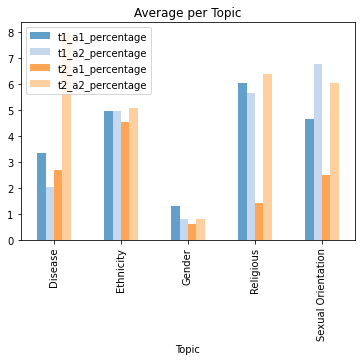

In [224]:
sns.set_palette(sns.color_palette("tab20"))

ax = avgFrame.plot(x="Topic", 
              y=["t1_a1_percentage", "t1_a2_percentage", "t2_a1_percentage", "t2_a2_percentage"],
              alpha = 0.7,
                    title = "Average per Topic"
              , kind="bar")

ax.figure.savefig('avg_perTopic.jpg', bbox_inches = "tight")

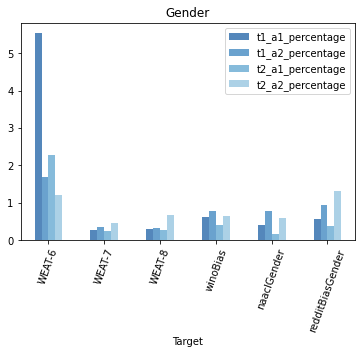

In [233]:
totalEvaluation_dfgender = totalEvaluation_df[totalEvaluation_df['Topic'] == 'Gender']

sns.set_palette(sns.color_palette("Blues_r"))

ax = totalEvaluation_dfgender.plot(x="Target", 
              y=["t1_a1_percentage", "t1_a2_percentage", "t2_a1_percentage", "t2_a2_percentage"],
              alpha = 0.7,
                    title = "Gender"
              , kind="bar")

plt.xticks(rotation=70)

ax.figure.savefig('total_gender.jpg', bbox_inches = "tight")

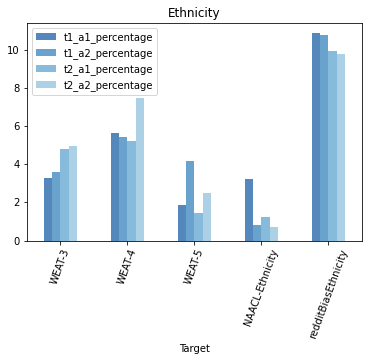

In [230]:
totalEvaluation_dfethnicity = totalEvaluation_df[totalEvaluation_df['Topic'] == 'Ethnicity']

sns.set_palette(sns.color_palette("Blues_r"))

ax = totalEvaluation_dfethnicity.plot(x="Target", 
              y=["t1_a1_percentage", "t1_a2_percentage", "t2_a1_percentage", "t2_a2_percentage"],
              alpha = 0.7,
                    title = "Ethnicity"
              , kind="bar")

plt.xticks(rotation=70)

ax.figure.savefig('total_ethnicity.jpg', bbox_inches = "tight")

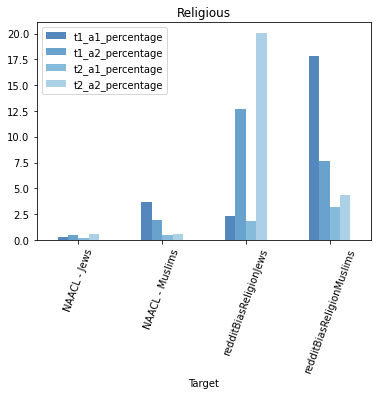

In [231]:
totalEvaluation_dfreligious = totalEvaluation_df[totalEvaluation_df['Topic'] == 'Religious']

sns.set_palette(sns.color_palette("Blues_r"))

ax = totalEvaluation_dfreligious.plot(x="Target", 
              y=["t1_a1_percentage", "t1_a2_percentage", "t2_a1_percentage", "t2_a2_percentage"],
              alpha = 0.7,
                    title = "Religious"
              , kind="bar")

plt.xticks(rotation=70)

ax.figure.savefig('total_religious.jpg', bbox_inches = "tight")

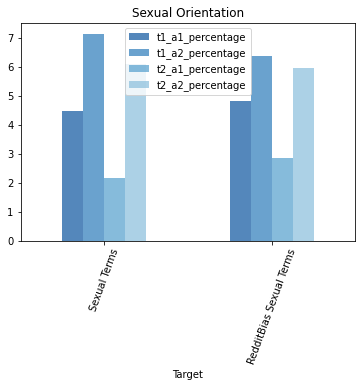

In [232]:
totalEvaluation_dfsexualOrientation = totalEvaluation_df[totalEvaluation_df['Topic'] == 'Sexual Orientation']

sns.set_palette(sns.color_palette("Blues_r"))

ax = totalEvaluation_dfsexualOrientation.plot(x="Target", 
              y=["t1_a1_percentage", "t1_a2_percentage", "t2_a1_percentage", "t2_a2_percentage"],
              alpha = 0.7,
                    title = "Sexual Orientation"
              , kind="bar")

plt.xticks(rotation=70)

ax.figure.savefig('total_sexual_or.jpg', bbox_inches = "tight")

## DEEP Dive

In [271]:
rb_sexor_deepdive = df_debate_redditBiasSexualOr[df_debate_redditBiasSexualOr['T1 x A1 Sentences'].str.len() > 0]

In [273]:
subset = rb_sexor_deepdive[rb_sexor_deepdive['gender'] == 'Genderqueer']

In [293]:
ethnicity_counts = df_debates['ethnicity'].value_counts()

In [308]:
gender_counts = df_debates['gender'].value_counts()

In [278]:
per_gender = rb_sexor_deepdive.groupby(by=['gender']).sum().reset_index()

In [289]:
per_ethnicity = rb_sexor_deepdive.groupby(by=['ethnicity']).sum().reset_index()

In [317]:
per_ethnicity

,ethnicity,year,minorityCount,majorityCount,T1 x A1 Count,T1 x A2 Count,T2 x A1 Count,T2 x A2 Count,ethnicityPercentage
0,Asian,136841,593,95,111,67,13,20,24356
1,Black,92654,328,52,63,27,4,3,12228
2,East Indian,18138,114,7,12,23,0,1,3566
3,Latino,195173,1080,95,144,231,16,2,9397
4,Middle Eastern,38282,129,11,59,10,5,6,3466
5,Native American,36261,75,10,23,9,4,0,3647
6,Not Saying,1643426,7771,1172,1353,736,118,89,242950
7,Other,161081,646,74,149,68,9,10,16764
8,Pacific Islander,4021,10,5,3,1,0,1,1641
9,White,2001245,9097,1438,1529,673,144,105,192756


In [305]:
def getEthnicityCount(row):
    count = None
    try: 
        count = ethnicity_counts[row['ethnicity']] 
    except KeyError:
        print('No such key')
    return count

In [311]:
def getGenderCount(row):
    count = None
    try: 
        count = gender_counts[row['gender']] 
    except KeyError:
        print('No such key')
    return count

In [306]:
per_ethnicity['ethnicityPercentage'] = per_ethnicity.apply(lambda row: getEthnicityCount(row), axis = 1)

In [312]:
per_gender['genderCount'] = per_gender.apply(lambda row: getGenderCount(row), axis = 1)

In [314]:
per_gender['T1 x A1 Proportional'] = per_gender.apply(lambda row: (row['T1 x A1 Count'] / row['genderCount']) * 100 , axis = 1)
per_gender['T1 x A2 Proportional'] = per_gender.apply(lambda row: (row['T1 x A2 Count'] / row['genderCount']) * 100 , axis = 1)
per_gender['T2 x A1 Proportional'] = per_gender.apply(lambda row: (row['T2 x A1 Count'] / row['genderCount']) * 100 , axis = 1)
per_gender['T2 x A2 Proportional'] = per_gender.apply(lambda row: (row['T2 x A2 Count'] / row['genderCount']) * 100 , axis = 1)

In [318]:
per_ethnicity['T1 x A1 Proportional'] = per_ethnicity.apply(lambda row: (row['T1 x A1 Count'] / row['ethnicityPercentage']) * 100 , axis = 1)
per_ethnicity['T1 x A2 Proportional'] = per_ethnicity.apply(lambda row: (row['T1 x A2 Count'] / row['ethnicityPercentage']) * 100 , axis = 1)
per_ethnicity['T2 x A1 Proportional'] = per_ethnicity.apply(lambda row: (row['T2 x A1 Count'] / row['ethnicityPercentage']) * 100 , axis = 1)
per_ethnicity['T2 x A2 Proportional'] = per_ethnicity.apply(lambda row: (row['T2 x A2 Count'] / row['ethnicityPercentage']) * 100 , axis = 1)

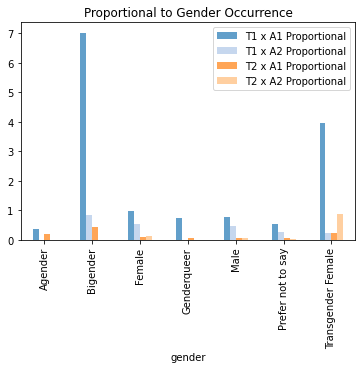

In [319]:
sns.set_palette(sns.color_palette("tab20"))

ax = per_gender.plot(x="gender", 
              y=["T1 x A1 Proportional", "T1 x A2 Proportional", "T2 x A1 Proportional", "T2 x A2 Proportional"],
              alpha = 0.7,
                    title = "Proportional to Gender Occurrence"
              , kind="bar")

ax.figure.savefig('bisSexualPerGender.jpg', bbox_inches = "tight")

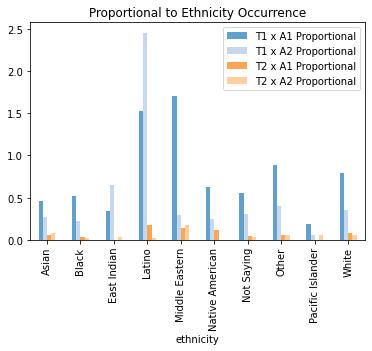

In [321]:
sns.set_palette(sns.color_palette("tab20"))

ax = per_ethnicity.plot(x="ethnicity", 
              y=["T1 x A1 Proportional", "T1 x A2 Proportional", "T2 x A1 Proportional", "T2 x A2 Proportional"],
              alpha = 0.7,
                    title = "Proportional to Ethnicity Occurrence"
              , kind="bar")

ax.figure.savefig('bisSexualPerEthnicity.jpg', bbox_inches = "tight")

In [328]:
subset = rb_sexor_deepdive[rb_sexor_deepdive['ethnicity'] == 'Latino']

In [329]:
subset[['title', 'argument','T1 x A1 Sentences', 'T1 x A1 Tuples Found']]

title  \
20075                                  Alcohol age in America should remain at 21   
49570                                                     Being gay is not a sin.   
49572                                                     Being gay is not a sin.   
136079                                                             Gay Marriage I   
136081                                                             Gay Marriage I   
...                                                                           ...   
438408                                       The Social Effects of Sin in America   
438410                                       The Social Effects of Sin in America   
460056  This house regrets the lack of date rape protection tools marketed to men   
466219                                      Transgenders and Using their Pronouns   
466223                                      Transgenders and Using their Pronouns   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [330]:
rb_relMuslim_deepdive = df_debate_redditBiasReligionMuslims[df_debate_redditBiasReligionMuslims['T1 x A1 Sentences'].str.len() > 0]

In [331]:
rb_relMuslim_deepdive

argument  \
1275                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [332]:
per_ethnicity = rb_relMuslim_deepdive.groupby(by=['ethnicity']).sum().reset_index()

In [334]:
per_ethnicity['ethnicityPercentage'] = per_ethnicity.apply(lambda row: getEthnicityCount(row), axis = 1)

In [335]:
per_ethnicity['T1 x A1 Proportional'] = per_ethnicity.apply(lambda row: (row['T1 x A1 Count'] / row['ethnicityPercentage']) * 100 , axis = 1)
per_ethnicity['T1 x A2 Proportional'] = per_ethnicity.apply(lambda row: (row['T1 x A2 Count'] / row['ethnicityPercentage']) * 100 , axis = 1)
per_ethnicity['T2 x A1 Proportional'] = per_ethnicity.apply(lambda row: (row['T2 x A1 Count'] / row['ethnicityPercentage']) * 100 , axis = 1)
per_ethnicity['T2 x A2 Proportional'] = per_ethnicity.apply(lambda row: (row['T2 x A2 Count'] / row['ethnicityPercentage']) * 100 , axis = 1)

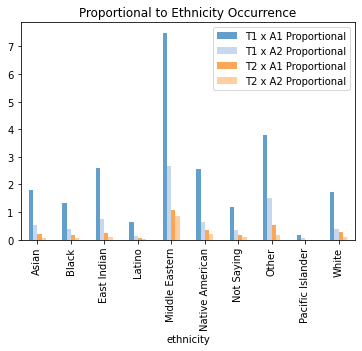

In [336]:
sns.set_palette(sns.color_palette("tab20"))

ax = per_ethnicity.plot(x="ethnicity", 
              y=["T1 x A1 Proportional", "T1 x A2 Proportional", "T2 x A1 Proportional", "T2 x A2 Proportional"],
              alpha = 0.7,
                    title = "Proportional to Ethnicity Occurrence"
              , kind="bar")

ax.figure.savefig('bisSexualPerEthnicity.jpg', bbox_inches = "tight")

In [337]:
subset = rb_relMuslim_deepdive[rb_relMuslim_deepdive['ethnicity'] == 'Middle Eastern']

In [338]:
subset[['title', 'argument','T1 x A1 Sentences', 'T1 x A1 Tuples Found']]

title  \
2308                                                                        9-11 was not a Muslim happy-hour   
2310                                                                        9-11 was not a Muslim happy-hour   
47246   Bashar al-Assad and the Syrian government (Pro/For) or FSA and other opposition forces (Con/Against)   
47261                                                                  Bashar al-assad should stay in power.   
71465                                                               Christianity is more peaceful than Islam   
...                                                                                                      ...   
464120                         To show that Solarman is one seriously messed-up person with regards to Islam   
464122                         To show that Solarman is one seriously messed-up person with regards to Islam   
491317                           which makes more sense ? islam(christianity)(judaism)(pro) vs atheism( con)   
495827                                         Why do some people deny the existence of God? (Only Atheists)   
505813                                                         Xtianity just another example of idol worship   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [342]:
pol_ideol_counts = df_debates['political_ideology'].value_counts()

In [340]:
per_pol_ideology = rb_relMuslim_deepdive.groupby(by=['political_ideology']).sum().reset_index()

In [344]:
def getPolIdeologyCount(row):
    count = None
    try: 
        count = pol_ideol_counts[row['political_ideology']] 
    except KeyError:
        print('No such key')
    return count

In [345]:
per_pol_ideology['ideologyCount'] = per_pol_ideology.apply(lambda row: getPolIdeologyCount(row), axis = 1)

In [346]:
per_pol_ideology['T1 x A1 Proportional'] = per_pol_ideology.apply(lambda row: (row['T1 x A1 Count'] / row['ideologyCount']) * 100 , axis = 1)
per_pol_ideology['T1 x A2 Proportional'] = per_pol_ideology.apply(lambda row: (row['T1 x A2 Count'] / row['ideologyCount']) * 100 , axis = 1)
per_pol_ideology['T2 x A1 Proportional'] = per_pol_ideology.apply(lambda row: (row['T2 x A1 Count'] / row['ideologyCount']) * 100 , axis = 1)
per_pol_ideology['T2 x A2 Proportional'] = per_pol_ideology.apply(lambda row: (row['T2 x A2 Count'] / row['ideologyCount']) * 100 , axis = 1)

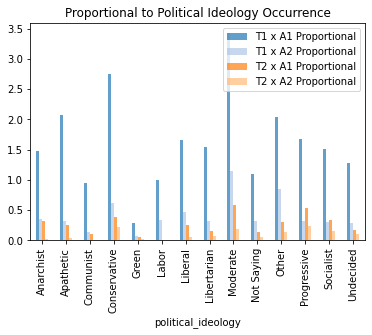

In [347]:
sns.set_palette(sns.color_palette("tab20"))

ax = per_pol_ideology.plot(x="political_ideology", 
              y=["T1 x A1 Proportional", "T1 x A2 Proportional", "T2 x A1 Proportional", "T2 x A2 Proportional"],
              alpha = 0.7,
                    title = "Proportional to Political Ideology Occurrence"
              , kind="bar")

ax.figure.savefig('bisSexualPerIdeology.jpg', bbox_inches = "tight")

In [351]:
subset = rb_relMuslim_deepdive[rb_relMuslim_deepdive['political_ideology'] == 'Moderate']

In [352]:
subset[['title', 'argument','T1 x A1 Sentences', 'T1 x A1 Tuples Found']][:20]

title  \
2112                                              9/11 was a false flag event   
2116                                              9/11 was a false flag event   
2261                                                   9/11 was an Inside Job   
15674  abortionist tiller should have been shot... from a prolife perspective   
15676  abortionist tiller should have been shot... from a prolife perspective   
17253                                       Adolph Hitler was a closet Muslim   
17257                                       Adolph Hitler was a closet Muslim   
22882       Allah is the Antichrist of the book of Revelation in Christianity   
23021                               Allow Muslim immigrants equal opporunity.   
23138                  Allowing Refugees from Syria is an all around bad idea   
23140                  Allowing Refugees from Syria is an all around bad idea   
23142                  Allowing Refugees from Syria is an all around bad idea   
24455                            America is the biggest threat to world peace   
24457                            America is the biggest threat to world peace   
25018                              America will never win the 'War on Terror'   
25020                              America will never win the 'War on Terror'   
25022                              America will never win the 'War on Terror'   
25263                                American Involvment in Middle East Peace   
25265                                American Involvment in Middle East Peace   
25269                                American Involvment in Middle East Peace   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

### Subset 2007-2008-2009

In [79]:
df_debate_2007_2009 = df_debates[df_debates['year'] < 2010]

In [74]:
len(df_debate_2007_2009)

43418

In [76]:
# Gender
weat_6_outcome_2007_2009, df_debate_2007_2009_weat_6 = calculateSummarySentences(df_debate_2007_2009, weat_6)

weat_7_outcome_2007_2009, df_debate_2007_2009_weat_7 = calculateSummarySentences(df_debate_2007_2009, weat_7)

weat_8_outcome_2007_2009, df_debate_2007_2009_weat_8 = calculateSummarySentences(df_debate_2007_2009, weat_8)

winoBias_outcome_2007_2009, df_debate_2007_2009_winoBias = calculateSummarySentences(df_debate_2007_2009, winoBias)

naaclGender_outcome_2007_2009, df_debate_2007_2009_naaclGender = calculateSummarySentences(df_debate_2007_2009, naaclGender)

redditBiasGender_outcome_2007_2009, df_debate_2007_2009_redditBiasGender = calculateSummarySentences(df_debate_2007_2009, redditBiasGender)

100%|███████████████████████████████████████████████████████████████████████████| 43418/43418 [02:16<00:00, 318.55it/s]


In [77]:
# Ethnicity
weat_3_outcome_2007_2009, df_debate_2007_2009_weat_3 = calculateSummarySentences(df_debate_2007_2009, weat_3)

weat_4_outcome_2007_2009, df_debate_2007_2009_weat_4 = calculateSummarySentences(df_debate_2007_2009, weat_4)

weat_5_outcome_2007_2009, df_debate_2007_2009_weat_5 = calculateSummarySentences(df_debate_2007_2009, weat_5)

naacl_outcome_2007_2009, df_debate_2007_2009_naacl = calculateSummarySentences(df_debate_2007_2009, naacl)

redditBiasEthnicity_outcome_2007_2009, df_debate_2007_2009_redditBiasEthnicity = calculateSummarySentences(df_debate_2007_2009, redditBiasEthnicity)

100%|███████████████████████████████████████████████████████████████████████████| 43418/43418 [02:21<00:00, 307.90it/s]


In [78]:
# Religious
jews_outcome_2007_2009, df_debate_2007_2009_jews = calculateSummarySentences(df_debate_2007_2009, religiousTermsJews)

muslims_outcome_2007_2009, df_debate_2007_2009_muslims = calculateSummarySentences(df_debate_2007_2009, religiousTermsMuslims)

redditBiasReligionJews_outcome_2007_2009, df_debate_2007_2009_redditBiasReligionJews = calculateSummarySentences(df_debate_2007_2009, redditBiasReligionJews)

redditBiasReligionMuslims_outcome_2007_2009, df_debate_2007_2009_redditBiasReligionMuslims = calculateSummarySentences(df_debate_2007_2009, redditBiasReligionMuslims)

100%|███████████████████████████████████████████████████████████████████████████| 43418/43418 [05:36<00:00, 128.95it/s]


In [79]:
# Sexual Terms
sexualTerms_outcome_2007_2009, df_debate_2007_2009_sexualTerms = calculateSummarySentences(df_debate_2007_2009, sexualTerms)

redditBiasSexualOr_outcome_2007_2009, df_debate_2007_2009_redditBiasSexualOr = calculateSummarySentences(df_debate_2007_2009, redditBiasSexualOr)

100%|███████████████████████████████████████████████████████████████████████████| 43418/43418 [01:58<00:00, 366.92it/s]


In [80]:
# Disease & Disability
weat_9_outcome_2007_2009, df_debate_2007_2009_weat_9 = calculateSummarySentences(df_debate_2007_2009, weat_9)

disease_healthy_outcome_2007_2009, df_debate_2007_2009_disease_healthy = calculateSummarySentences(df_debate_2007_2009, disease_healthy)

100%|██████████████████████████████████████████████████████████████████████████| 43418/43418 [00:17<00:00, 2529.26it/s]


#### Subset 2010-2012

In [77]:
df_debate_2010_2012 = df_debates[(df_debates['year'] < 2013) & (df_debates['year'] > 2010)]

In [82]:
len(df_debate_2010_2012)

69174

In [84]:
# Gender
weat_6_outcome_2010_2012, df_debate_2010_2012_weat_6 = calculateSummarySentences(df_debate_2010_2012, weat_6)

weat_7_outcome_2010_2012, df_debate_2010_2012_weat_7 = calculateSummarySentences(df_debate_2010_2012, weat_7)

weat_8_outcome_2010_2012, df_debate_2010_2012_weat_8 = calculateSummarySentences(df_debate_2010_2012, weat_8)

winoBias_outcome_2010_2012, df_debate_2010_2012_winoBias = calculateSummarySentences(df_debate_2010_2012, winoBias)

naaclGender_outcome_2010_2012, df_debate_2010_2012_naaclGender = calculateSummarySentences(df_debate_2010_2012, naaclGender)

redditBiasGender_outcome_2010_2012, df_debate_2010_2012_redditBiasGender = calculateSummarySentences(df_debate_2010_2012, redditBiasGender)

100%|███████████████████████████████████████████████████████████████████████████| 69174/69174 [10:30<00:00, 109.77it/s]


In [85]:
# Ethnicity
weat_3_outcome_2010_2012, df_debate_2010_2012_weat_3 = calculateSummarySentences(df_debate_2010_2012, weat_3)

weat_4_outcome_2010_2012, df_debate_2010_2012_weat_4 = calculateSummarySentences(df_debate_2010_2012, weat_4)

weat_5_outcome_2010_2012, df_debate_2010_2012_weat_5 = calculateSummarySentences(df_debate_2010_2012, weat_5)

naacl_outcome_2010_2012, df_debate_2010_2012_naacl = calculateSummarySentences(df_debate_2010_2012, naacl)

redditBiasEthnicity_outcome_2010_2012, df_debate_2010_2012_redditBiasEthnicity = calculateSummarySentences(df_debate_2010_2012, redditBiasEthnicity)

100%|███████████████████████████████████████████████████████████████████████████| 69174/69174 [11:09<00:00, 103.31it/s]


In [87]:
# Religious
jews_outcome_2010_2012, df_debate_2010_2012_jews = calculateSummarySentences(df_debate_2010_2012, religiousTermsJews)

muslims_outcome_2010_2012, df_debate_2010_2012_muslims = calculateSummarySentences(df_debate_2010_2012, religiousTermsMuslims)

redditBiasReligionJews_outcome_2010_2012, df_debate_2010_2012_redditBiasReligionJews = calculateSummarySentences(df_debate_2010_2012, redditBiasReligionJews)

redditBiasReligionMuslims_outcome_2010_2012, df_debate_2010_2012_redditBiasReligionMuslims = calculateSummarySentences(df_debate_2010_2012, redditBiasReligionMuslims)

100%|███████████████████████████████████████████████████████████████████████████| 69174/69174 [02:13<00:00, 517.13it/s]


In [88]:
# Sexual Terms
sexualTerms_outcome_2010_2012, df_debate_2010_2012_sexualTerms = calculateSummarySentences(df_debate_2010_2012, sexualTerms)

redditBiasSexualOr_outcome_2010_2012, df_debate_2010_2012_redditBiasSexualOr = calculateSummarySentences(df_debate_2010_2012, redditBiasSexualOr)

100%|███████████████████████████████████████████████████████████████████████████| 69174/69174 [02:52<00:00, 400.05it/s]


In [89]:
# Disease & Disability
weat_9_outcome_2010_2012, df_debate_2010_2012_weat_9 = calculateSummarySentences(df_debate_2010_2012, weat_9)

disease_healthy_outcome_2010_2012, df_debate_2010_2012_disease_healthy = calculateSummarySentences(df_debate_2010_2012, disease_healthy)

100%|██████████████████████████████████████████████████████████████████████████| 69174/69174 [00:23<00:00, 2982.05it/s]


#### Subset 2013-2015

In [33]:
df_debate_2013_2015 = df_debates[(df_debates['year'] < 2016) & (df_debates['year'] > 2012)]

In [34]:
len(df_debate_2013_2015)

252018

In [92]:
# Gender
weat_6_outcome_2013_2015, df_debate_2013_2015_weat_6 = calculateSummarySentences(df_debate_2013_2015, weat_6)

weat_7_outcome_2013_2015, df_debate_2013_2015_weat_7 = calculateSummarySentences(df_debate_2013_2015, weat_7)

weat_8_outcome_2013_2015, df_debate_2013_2015_weat_8 = calculateSummarySentences(df_debate_2013_2015, weat_8)

winoBias_outcome_2013_2015, df_debate_2013_2015_winoBias = calculateSummarySentences(df_debate_2013_2015, winoBias)

naaclGender_outcome_2013_2015, df_debate_2013_2015_naaclGender = calculateSummarySentences(df_debate_2013_2015, naaclGender)

redditBiasGender_outcome_2013_2015, df_debate_2013_2015_redditBiasGender = calculateSummarySentences(df_debate_2013_2015, redditBiasGender)

100%|█████████████████████████████████████████████████████████████████████████| 252018/252018 [16:38<00:00, 252.52it/s]


In [93]:
# Ethnicity
weat_3_outcome_2013_2015, df_debate_2013_2015_weat_3 = calculateSummarySentences(df_debate_2013_2015, weat_3)

weat_4_outcome_2013_2015, df_debate_2013_2015_weat_4 = calculateSummarySentences(df_debate_2013_2015, weat_4)

weat_5_outcome_2013_2015, df_debate_2013_2015_weat_5 = calculateSummarySentences(df_debate_2013_2015, weat_5)

naacl_outcome_2013_2015, df_debate_2013_2015_naacl = calculateSummarySentences(df_debate_2013_2015, naacl)

redditBiasEthnicity_outcome_2013_2015, df_debate_2013_2015_redditBiasEthnicity = calculateSummarySentences(df_debate_2013_2015, redditBiasEthnicity)

100%|█████████████████████████████████████████████████████████████████████████| 252018/252018 [07:13<00:00, 580.95it/s]


In [35]:
# Religious
jews_outcome_2013_2015, df_debate_2013_2015_jews = calculateSummarySentences(df_debate_2013_2015, religiousTermsJews)

muslims_outcome_2013_2015, df_debate_2013_2015_muslims = calculateSummarySentences(df_debate_2013_2015, religiousTermsMuslims)

redditBiasReligionJews_outcome_2013_2015, df_debate_2013_2015_redditBiasReligionJews = calculateSummarySentences(df_debate_2013_2015, redditBiasReligionJews)

redditBiasReligionMuslims_outcome_2013_2015, df_debate_2013_2015_redditBiasReligionMuslims = calculateSummarySentences(df_debate_2013_2015, redditBiasReligionMuslims)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 252018/252018 [06:24<00:00, 655.06it/s]


In [36]:
# Sexual Terms
sexualTerms_outcome_2013_2015, df_debate_2013_2015_sexualTerms = calculateSummarySentences(df_debate_2013_2015, sexualTerms)

redditBiasSexualOr_outcome_2013_2015, df_debate_2013_2015_sexualTerms = calculateSummarySentences(df_debate_2013_2015, redditBiasSexualOr)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 252018/252018 [07:37<00:00, 550.83it/s]


In [37]:
# Disease & Disability
weat_9_outcome_2013_2015, df_debate_2013_2015_weat_9 = calculateSummarySentences(df_debate_2013_2015, weat_9)

disease_healthy_outcome_2013_2015, df_debate_2013_2015_disease_healthy = calculateSummarySentences(df_debate_2013_2015, disease_healthy)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 252018/252018 [01:29<00:00, 2809.09it/s]


#### Subset 2016-2018

In [38]:
df_debate_2016_2018 = df_debates[(df_debates['year'] > 2015)]

In [39]:
len(df_debate_2016_2018)

130921

In [40]:
# Gender
weat_6_outcome_2016_2018, df_debate_2016_2018_weat_6 = calculateSummarySentences(df_debate_2016_2018, weat_6)

weat_7_outcome_2016_2018, df_debate_2016_2018_weat_7 = calculateSummarySentences(df_debate_2016_2018, weat_7)

weat_8_outcome_2016_2018, df_debate_2016_2018_weat_8 = calculateSummarySentences(df_debate_2016_2018, weat_8)

winoBias_outcome_2016_2018, df_debate_2016_2018_winoBias = calculateSummarySentences(df_debate_2016_2018, winoBias)

naaclGender_outcome_2016_2018, df_debate_2016_2018_naaclGender = calculateSummarySentences(df_debate_2016_2018, naaclGender)

redditBiasGender_outcome_2016_2018, df_debate_2016_2018_redditBiasGender = calculateSummarySentences(df_debate_2016_2018, redditBiasGender)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130921/130921 [04:03<00:00, 537.95it/s]


In [41]:
# Ethnicity
weat_3_outcome_2016_2018, df_debate_2016_2018_weat_3 = calculateSummarySentences(df_debate_2016_2018, weat_3)

weat_4_outcome_2016_2018, df_debate_2016_2018_weat_4 = calculateSummarySentences(df_debate_2016_2018, weat_4)

weat_5_outcome_2016_2018, df_debate_2016_2018_weat_5 = calculateSummarySentences(df_debate_2016_2018, weat_5)

naacl_outcome_2016_2018, df_debate_2016_2018_naacl = calculateSummarySentences(df_debate_2016_2018, naacl)

redditBiasEthnicity_outcome_2016_2018, df_debate_2016_2018_redditBiasEthnicity = calculateSummarySentences(df_debate_2016_2018, redditBiasEthnicity)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130921/130921 [03:42<00:00, 588.85it/s]


In [43]:
# Religious
jews_outcome_2016_2018, df_debate_2016_2018_jews = calculateSummarySentences(df_debate_2016_2018, religiousTermsJews)

muslims_outcome_2016_2018, df_debate_2016_2018_muslims = calculateSummarySentences(df_debate_2016_2018, religiousTermsMuslims)

redditBiasReligionJews_outcome_2016_2018, df_debate_2016_2018_redditBiasReligionJews = calculateSummarySentences(df_debate_2016_2018, redditBiasReligionJews)

redditBiasReligionMuslims_outcome_2016_2018, df_debate_2016_2018_redditBiasReligionMuslims = calculateSummarySentences(df_debate_2016_2018, redditBiasReligionMuslims)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130921/130921 [02:34<00:00, 846.50it/s]


In [44]:
# Sexual Terms
sexualTerms_outcome_2016_2018, df_debate_2016_2018_sexualTerms = calculateSummarySentences(df_debate_2016_2018, sexualTerms)

redditBiasSexualOr_outcome_2016_2018, df_debate_2016_2018_redditBiasSexualOr = calculateSummarySentences(df_debate_2016_2018, redditBiasSexualOr)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130921/130921 [03:10<00:00, 686.35it/s]


In [45]:
# Disease & Disability
weat_9_outcome_2016_2018, df_debate_2016_2018_weat_9 = calculateSummarySentences(df_debate_2016_2018, weat_9)

disease_healthy_outcome_2016_2018, df_debate_2016_2018_disease_healthy = calculateSummarySentences(df_debate_2016_2018, disease_healthy)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130921/130921 [00:38<00:00, 3424.20it/s]


## Evaluation

#### GENDER

In [51]:
timeEvaluationList_gender = []
# WEAT - 6
#timeEvaluationList_gender.append(['2007 to 2009', 'WEAT-6', *weat_6_outcome_2007_2009])
#timeEvaluationList_gender.append(['2010 to 2012', 'WEAT-6', *weat_6_outcome_2010_2012])
#timeEvaluationList_gender.append(['2013 to 2015', 'WEAT-6', *weat_6_outcome_2013_2015])
timeEvaluationList_gender.append(['2016 to 2018', 'WEAT-6', *weat_6_outcome_2016_2018])
# WEAT - 7
#timeEvaluationList_gender.append(['2007 to 2009', 'WEAT-7', *weat_7_outcome_2007_2009])
#timeEvaluationList_gender.append(['2010 to 2012', 'WEAT-7', *weat_7_outcome_2010_2012])
#timeEvaluationList_gender.append(['2013 to 2015', 'WEAT-7', *weat_7_outcome_2013_2015])
timeEvaluationList_gender.append(['2016 to 2018', 'WEAT-7', *weat_7_outcome_2016_2018])
# WEAT - 8
#timeEvaluationList_gender.append(['2007 to 2009', 'WEAT-8', *weat_8_outcome_2007_2009])
#timeEvaluationList_gender.append(['2010 to 2012', 'WEAT-8', *weat_8_outcome_2010_2012])
#timeEvaluationList_gender.append(['2013 to 2015', 'WEAT-8', *weat_8_outcome_2013_2015])
timeEvaluationList_gender.append(['2016 to 2018', 'WEAT-8', *weat_8_outcome_2016_2018])
# WinoBias (Zhao et. al)
#timeEvaluationList_gender.append(['2007 to 2009', 'winoBias', *winoBias_outcome_2007_2009])
#timeEvaluationList_gender.append(['2010 to 2012', 'winoBias', *winoBias_outcome_2010_2012])
#timeEvaluationList_gender.append(['2013 to 2015', 'winoBias', *winoBias_outcome_2013_2015])
timeEvaluationList_gender.append(['2016 to 2018', 'winoBias', *winoBias_outcome_2016_2018])
# NAACL
#timeEvaluationList_gender.append(['2007 to 2009', 'naaclGender', *naaclGender_outcome_2007_2009])
#timeEvaluationList_gender.append(['2010 to 2012', 'naaclGender', *naaclGender_outcome_2010_2012])
#timeEvaluationList_gender.append(['2013 to 2015', 'naaclGender', *naaclGender_outcome_2013_2015])
timeEvaluationList_gender.append(['2016 to 2018', 'naaclGender', *naaclGender_outcome_2016_2018])
# RedditBias
#timeEvaluationList_gender.append(['2007 to 2009', 'redditBiasGender', *redditBiasGender_outcome_2007_2009])
#timeEvaluationList_gender.append(['2010 to 2012', 'redditBiasGender', *redditBiasGender_outcome_2010_2012])
#timeEvaluationList_gender.append(['2013 to 2015', 'redditBiasGender', *redditBiasGender_outcome_2013_2015])
timeEvaluationList_gender.append(['2016 to 2018', 'redditBiasGender', *redditBiasGender_outcome_2016_2018])

In [52]:
columns = ['Year', 'Target', 'totalMinorityOccurrence', 'totalMajorityOccurrence', 't1_a1_total', 't1_a1_percentage', 't1_a2_total', 't1_a2_percentage', 't2_a1_total', 't2_a1_percentage', 't2_a2_total', 't2_a2_percentage']

time_evaluation_gender2 = pd.DataFrame(timeEvaluationList_gender, columns = columns)

In [123]:
time_evaluation_gender.to_csv('time_evaluation_gender.csv')

In [54]:
time_evaluation_gender = pd.concat([time_evaluation_gender, time_evaluation_gender2])

In [57]:
time_evaluation_gender

,Year,Target,totalMinorityOccurrence,totalMajorityOccurrence,t1_a1_total,t1_a1_percentage,t1_a2_total,t1_a2_percentage,t2_a1_total,t2_a1_percentage,t2_a2_total,t2_a2_percentage
0,2007 to 2009,WEAT-6,502.0,6336.0,21.0,4.18,12.0,2.39,152.0,2.40,115.0,1.82
1,2010 to 2012,WEAT-6,418.0,9620.0,35.0,8.37,5.0,1.20,195.0,2.03,121.0,1.26
2,2013 to 2015,WEAT-6,1081.0,19233.0,58.0,5.37,19.0,1.76,446.0,2.32,195.0,1.01
3,2007 to 2009,WEAT-7,26153.0,127774.0,68.0,0.26,91.0,0.35,214.0,0.17,562.0,0.44
4,2010 to 2012,WEAT-7,35622.0,194531.0,93.0,0.26,126.0,0.35,506.0,0.26,923.0,0.47
5,2013 to 2015,WEAT-7,99431.0,437378.0,315.0,0.32,298.0,0.30,1161.0,0.27,1873.0,0.43
6,2007 to 2009,WEAT-8,23865.0,118468.0,54.0,0.23,69.0,0.29,213.0,0.18,707.0,0.60
7,2010 to 2012,WEAT-8,30659.0,182540.0,89.0,0.29,89.0,0.29,507.0,0.28,1155.0,0.63
8,2013 to 2015,WEAT-8,87028.0,403791.0,295.0,0.34,314.0,0.36,1170.0,0.29,2872.0,0.71
9,2007 to 2009,winoBias,39817.0,148583.0,276.0,0.69,295.0,0.74,677.0,0.46,1054.0,0.71


#### ETHNICITY

In [129]:
time_evaluation_ethnicity = pd.read_csv('time_evaluation_ethnicity.csv')

In [130]:
timeEvaluationList_ethnicity = []
# WEAT - 3
#timeEvaluationList_ethnicity.append(['2007 to 2009', 'WEAT-3', *weat_3_outcome_2007_2009])
#timeEvaluationList_ethnicity.append(['2010 to 2012', 'WEAT-3', *weat_3_outcome_2010_2012])
#timeEvaluationList_ethnicity.append(['2013 to 2015', 'WEAT-3', *weat_3_outcome_2013_2015])
timeEvaluationList_ethnicity.append(['2016 to 2018', 'WEAT-3', *weat_3_outcome_2016_2018])
# WEAT - 4
#timeEvaluationList_ethnicity.append(['2007 to 2009', 'WEAT-4', *weat_4_outcome_2007_2009])
#timeEvaluationList_ethnicity.append(['2010 to 2012', 'WEAT-4', *weat_4_outcome_2010_2012])
#timeEvaluationList_ethnicity.append(['2013 to 2015', 'WEAT-4', *weat_4_outcome_2013_2015])
timeEvaluationList_ethnicity.append(['2016 to 2018', 'WEAT-4', *weat_4_outcome_2016_2018])
# WEAT - 5
#timeEvaluationList_ethnicity.append(['2007 to 2009', 'WEAT-5', *weat_5_outcome_2007_2009])
#timeEvaluationList_ethnicity.append(['2010 to 2012', 'WEAT-5', *weat_5_outcome_2010_2012])
#timeEvaluationList_ethnicity.append(['2013 to 2015', 'WEAT-5', *weat_5_outcome_2013_2015])
timeEvaluationList_ethnicity.append(['2016 to 2018', 'WEAT-5', *weat_5_outcome_2016_2018])
# NAACL - Ethnicity
#timeEvaluationList_ethnicity.append(['2007 to 2009', 'NAACL-Ethnicity', *naacl_outcome_2007_2009])
#timeEvaluationList_ethnicity.append(['2010 to 2012', 'NAACL-Ethnicity', *naacl_outcome_2010_2012])
#timeEvaluationList_ethnicity.append(['2013 to 2015', 'NAACL-Ethnicity', *naacl_outcome_2013_2015])
timeEvaluationList_ethnicity.append(['2016 to 2018', 'NAACL-Ethnicity', *naacl_outcome_2016_2018])
# RedditBias - Ethnicity
#timeEvaluationList_ethnicity.append(['2007 to 2009', 'redditBiasEthnicity', *redditBiasEthnicity_outcome_2007_2009])
#timeEvaluationList_ethnicity.append(['2010 to 2012', 'redditBiasEthnicity', *redditBiasEthnicity_outcome_2010_2012])
#timeEvaluationList_ethnicity.append(['2013 to 2015', 'redditBiasEthnicity', *redditBiasEthnicity_outcome_2013_2015])
timeEvaluationList_ethnicity.append(['2016 to 2018', 'redditBiasEthnicity', *redditBiasEthnicity_outcome_2016_2018])

In [131]:
columns = ['Year', 'Target', 'totalMinorityOccurrence', 'totalMajorityOccurrence', 't1_a1_total', 't1_a1_percentage', 't1_a2_total', 't1_a2_percentage', 't2_a1_total', 't2_a1_percentage', 't2_a2_total', 't2_a2_percentage']

time_evaluation_ethnicity2 = pd.DataFrame(timeEvaluationList_ethnicity, columns = columns)

In [134]:
time_evaluation_ethnicity.to_csv('time_evaluation_ethnicity.csv')

In [132]:
time_evaluation_ethnicity = pd.concat([time_evaluation_ethnicity, time_evaluation_ethnicity2])

In [133]:
time_evaluation_ethnicity.drop(columns = ['Unnamed: 0'], inplace = True)

In [136]:
time_evaluation_ethnicity

,Year,Target,totalMinorityOccurrence,totalMajorityOccurrence,t1_a1_total,t1_a1_percentage,t1_a2_total,t1_a2_percentage,t2_a1_total,t2_a1_percentage,t2_a2_total,t2_a2_percentage,DS size,minorityPercentage,majorityPercentage
0,2007 to 2009,WEAT-3,93.0,4982.0,5.0,5.38,7.0,7.53,240.0,4.82,239.0,4.80,43418.0,0.214197,11.474504
1,2010 to 2012,WEAT-3,142.0,11583.0,3.0,2.11,2.0,1.41,641.0,5.53,505.0,4.36,69174.0,0.205279,16.744731
2,2013 to 2015,WEAT-3,466.0,24339.0,17.0,3.65,18.0,3.86,1057.0,4.34,1172.0,4.82,252018.0,0.184907,9.657644
3,2007 to 2009,WEAT-4,105.0,949.0,14.0,13.33,11.0,10.48,49.0,5.16,65.0,6.85,43418.0,0.241835,2.185729
4,2010 to 2012,WEAT-4,198.0,2401.0,8.0,4.04,6.0,3.03,123.0,5.12,140.0,5.83,69174.0,0.286235,3.470957
5,2013 to 2015,WEAT-4,843.0,5283.0,38.0,4.51,47.0,5.58,253.0,4.79,387.0,7.33,252018.0,0.334500,2.096279
6,2007 to 2009,WEAT-5,105.0,949.0,1.0,0.95,8.0,7.62,14.0,1.48,27.0,2.85,43418.0,0.241835,2.185729
7,2010 to 2012,WEAT-5,198.0,2401.0,3.0,1.52,3.0,1.52,27.0,1.12,48.0,2.00,69174.0,0.286235,3.470957
8,2013 to 2015,WEAT-5,843.0,5283.0,19.0,2.25,38.0,4.51,66.0,1.25,115.0,2.18,252018.0,0.334500,2.096279
9,2007 to 2009,NAACL-Ethnicity,6028.0,19876.0,152.0,2.52,37.0,0.61,222.0,1.12,137.0,0.69,43418.0,13.883643,45.778249


#### RELIGION

In [63]:
time_evaluation_religious = pd.read_csv('time_evaluation_religious.csv')

In [65]:
timeEvaluationList_religious = []
# Religious - Jews
#timeEvaluationList_religious.append(['2007 to 2009', 'NAACL - Jews', *jews_outcome_2007_2009])
#timeEvaluationList_religious.append(['2010 to 2012', 'NAACL - Jews', *jews_outcome_2010_2012])
timeEvaluationList_religious.append(['2013 to 2015', 'NAACL - Jews', *jews_outcome_2013_2015])
timeEvaluationList_religious.append(['2016 to 2018', 'NAACL - Jews', *jews_outcome_2016_2018])
# Religious - Muslims
#timeEvaluationList_religious.append(['2007 to 2009', 'NAACL - Muslims', *muslims_outcome_2007_2009])
#timeEvaluationList_religious.append(['2010 to 2012', 'NAACL - Muslims', *muslims_outcome_2010_2012])
timeEvaluationList_religious.append(['2013 to 2015', 'NAACL - Muslims', *muslims_outcome_2013_2015])
timeEvaluationList_religious.append(['2016 to 2018', 'NAACL - Muslims', *muslims_outcome_2016_2018])
# RedditBias - Jews
#timeEvaluationList_religious.append(['2007 to 2009', 'redditBiasReligionJews', *redditBiasReligionJews_outcome_2007_2009])
#timeEvaluationList_religious.append(['2010 to 2012', 'redditBiasReligionJews', *redditBiasReligionJews_outcome_2010_2012])
timeEvaluationList_religious.append(['2013 to 2015', 'redditBiasReligionJews', *redditBiasReligionJews_outcome_2013_2015])
timeEvaluationList_religious.append(['2016 to 2018', 'redditBiasReligionJews', *redditBiasReligionJews_outcome_2016_2018])
# RedditBias - Muslims
#timeEvaluationList_religious.append(['2007 to 2009', 'redditBiasReligionMuslims', *redditBiasReligionMuslims_outcome_2007_2009])
#timeEvaluationList_religious.append(['2010 to 2012', 'redditBiasReligionMuslims', *redditBiasReligionMuslims_outcome_2010_2012])
timeEvaluationList_religious.append(['2013 to 2015', 'redditBiasReligionMuslims', *redditBiasReligionMuslims_outcome_2013_2015])
timeEvaluationList_religious.append(['2016 to 2018', 'redditBiasReligionMuslims', *redditBiasReligionMuslims_outcome_2016_2018])

In [66]:
columns = ['Year', 'Target', 'totalMinorityOccurrence', 'totalMajorityOccurrence', 't1_a1_total', 't1_a1_percentage', 't1_a2_total', 't1_a2_percentage', 't2_a1_total', 't2_a1_percentage', 't2_a2_total', 't2_a2_percentage']

time_evaluation_religious2 = pd.DataFrame(timeEvaluationList_religious, columns = columns)

In [121]:
time_evaluation_religious.to_csv('time_evaluation_religious.csv')

In [67]:
time_evaluation_religious = pd.concat([time_evaluation_religious, time_evaluation_religious2])

In [72]:
time_evaluation_religious.drop(columns = ['Unnamed: 0'], inplace = True)

In [137]:
time_evaluation_religious

,Year,Target,totalMinorityOccurrence,totalMajorityOccurrence,t1_a1_total,t1_a1_percentage,t1_a2_total,t1_a2_percentage,t2_a1_total,t2_a1_percentage,t2_a2_total,t2_a2_percentage,DS size,minorityPercentage,majorityPercentage
0,2007 to 2009,NAACL - Jews,2435.0,18315.0,6.0,0.25,14.0,0.57,54.0,0.29,113.0,0.62,43418,5.608273,42.182966
1,2010 to 2012,NAACL - Jews,4353.0,27806.0,1.0,0.02,19.0,0.44,23.0,0.08,141.0,0.51,69174,6.292827,40.197184
2,2007 to 2009,NAACL - Muslims,2811.0,18315.0,186.0,6.62,32.0,1.14,95.0,0.52,101.0,0.55,43418,6.474273,42.182966
3,2010 to 2012,NAACL - Muslims,5126.0,27806.0,141.0,2.75,98.0,1.91,73.0,0.26,135.0,0.49,69174,7.410299,40.197184
4,2007 to 2009,redditBiasReligionJews,2398.0,11315.0,57.0,2.38,316.0,13.18,301.0,2.66,2394.0,21.16,43418,5.523055,26.060620
5,2010 to 2012,redditBiasReligionJews,4288.0,16494.0,67.0,1.56,555.0,12.94,310.0,1.88,3434.0,20.82,69174,6.198861,23.844219
6,2007 to 2009,redditBiasReligionMuslims,3680.0,18315.0,898.0,24.40,293.0,7.96,597.0,3.26,787.0,4.30,43418,8.475747,42.182966
7,2010 to 2012,redditBiasReligionMuslims,5427.0,27806.0,991.0,18.26,398.0,7.33,588.0,2.11,1014.0,3.65,69174,7.845433,40.197184
0,2013 to 2015,NAACL - Jews,12074.0,78874.0,34.0,0.28,52.0,0.43,166.0,0.21,461.0,0.58,252018,4.790928,31.296971
1,2016 to 2018,NAACL - Jews,7353.0,38672.0,24.0,0.33,32.0,0.44,71.0,0.18,176.0,0.46,130921,5.616364,29.538424


#### SEXUAL TERMS

In [109]:
time_evaluation_sexual = pd.read_csv('time_evaluation_sexual.csv')

In [103]:
time_evaluation_sexual

,Year,Target,totalMinorityOccurrence,totalMajorityOccurrence,t1_a1_total,t1_a1_percentage,t1_a2_total,t1_a2_percentage,t2_a1_total,t2_a1_percentage,t2_a2_total,t2_a2_percentage,DS size,minorityPercentage,majorityPercentage
0,2007 to 2009,Sexual Terms,8174.0,1846.0,358.0,4.38,702.0,8.59,43.0,2.33,147.0,7.96,43418,18.826293,4.251693
1,2010 to 2012,Sexual Terms,14990.0,4306.0,529.0,3.53,1228.0,8.19,78.0,1.81,264.0,6.13,69174,21.669992,6.224882
0,2013 to 2015,Sexual Terms,32462.0,7602.0,1466.0,4.52,2155.0,6.64,156.0,2.05,435.0,5.72,252018,12.880826,3.016451
1,2016 to 2018,Sexual Terms,11590.0,2497.0,629.0,5.43,721.0,6.22,69.0,2.76,127.0,5.09,130921,8.852667,1.907257
2,2007 to 2009,Sexual Terms,8336.0,1846.0,355.0,4.26,383.0,4.59,40.0,2.17,94.0,5.09,43418,19.199410,4.251693
3,2010 to 2012,Sexual Terms,15199.0,4308.0,546.0,3.59,1037.0,6.82,91.0,2.11,192.0,4.46,69174,21.972128,6.227773
4,2013 to 2015,Sexual Terms,32878.0,7632.0,1699.0,5.17,2200.0,6.69,240.0,3.14,486.0,6.37,252018,13.045894,3.028355
5,2016 to 2018,Sexual Terms,12436.0,2551.0,746.0,6.00,774.0,6.22,96.0,3.76,201.0,7.88,130921,9.498858,1.948503


In [110]:
timeEvaluationList_sexual = []
#timeEvaluationList_sexual.append(['2007 to 2009', 'Sexual Terms', *sexualTerms_outcome_2007_2009])
#timeEvaluationList_sexual.append(['2010 to 2012', 'Sexual Terms', *sexualTerms_outcome_2010_2012])
timeEvaluationList_sexual.append(['2013 to 2015', 'Sexual Terms', *sexualTerms_outcome_2013_2015])
timeEvaluationList_sexual.append(['2016 to 2018', 'Sexual Terms', *sexualTerms_outcome_2016_2018])

timeEvaluationList_sexual.append(['2007 to 2009', 'RedditBias Sexual Terms', *redditBiasSexualOr_outcome_2007_2009])
timeEvaluationList_sexual.append(['2010 to 2012', 'RedditBias Sexual Terms', *redditBiasSexualOr_outcome_2010_2012])
timeEvaluationList_sexual.append(['2013 to 2015', 'RedditBias Sexual Terms', *redditBiasSexualOr_outcome_2013_2015])
timeEvaluationList_sexual.append(['2016 to 2018', 'RedditBias Sexual Terms', *redditBiasSexualOr_outcome_2016_2018])

In [111]:
columns = ['Year', 'Target', 'totalMinorityOccurrence', 'totalMajorityOccurrence', 't1_a1_total', 't1_a1_percentage', 't1_a2_total', 't1_a2_percentage', 't2_a1_total', 't2_a1_percentage', 't2_a2_total', 't2_a2_percentage']

time_evaluation_sexual2 = pd.DataFrame(timeEvaluationList_sexual, columns = columns)

In [120]:
time_evaluation_sexual.to_csv('time_evaluation_sexual.csv')

In [112]:
time_evaluation_sexual = pd.concat([time_evaluation_sexual, time_evaluation_sexual2])

In [114]:
time_evaluation_sexual.drop(columns = ['Unnamed: 0'], inplace = True)

In [116]:
time_evaluation_sexual

,Year,Target,totalMinorityOccurrence,totalMajorityOccurrence,t1_a1_total,t1_a1_percentage,t1_a2_total,t1_a2_percentage,t2_a1_total,t2_a1_percentage,t2_a2_total,t2_a2_percentage
0,2007 to 2009,Sexual Terms,8174.0,1846.0,358.0,4.38,702.0,8.59,43.0,2.33,147.0,7.96
1,2010 to 2012,Sexual Terms,14990.0,4306.0,529.0,3.53,1228.0,8.19,78.0,1.81,264.0,6.13
0,2013 to 2015,Sexual Terms,32462.0,7602.0,1466.0,4.52,2155.0,6.64,156.0,2.05,435.0,5.72
1,2016 to 2018,Sexual Terms,11590.0,2497.0,629.0,5.43,721.0,6.22,69.0,2.76,127.0,5.09
2,2007 to 2009,RedditBias Sexual Terms,8336.0,1846.0,355.0,4.26,383.0,4.59,40.0,2.17,94.0,5.09
3,2010 to 2012,RedditBias Sexual Terms,15199.0,4308.0,546.0,3.59,1037.0,6.82,91.0,2.11,192.0,4.46
4,2013 to 2015,RedditBias Sexual Terms,32878.0,7632.0,1699.0,5.17,2200.0,6.69,240.0,3.14,486.0,6.37
5,2016 to 2018,RedditBias Sexual Terms,12436.0,2551.0,746.0,6.00,774.0,6.22,96.0,3.76,201.0,7.88


#### Disease & Disability

In [85]:
time_evaluation_disease = pd.read_csv('time_evaluation_disease.csv')

In [86]:
timeEvaluationList_disease = []
# Disease - Permanent
#timeEvaluationList_disease.append(['2007 to 2009', 'WEAT-9', *weat_9_outcome_2007_2009])
#timeEvaluationList_disease.append(['2010 to 2012', 'WEAT-9', *weat_9_outcome_2010_2012])
timeEvaluationList_disease.append(['2013 to 2015', 'WEAT-9', *weat_9_outcome_2013_2015])
timeEvaluationList_disease.append(['2016 to 2018', 'WEAT-9', *weat_9_outcome_2016_2018])
# Disease - Healthy
#timeEvaluationList_disease.append(['2007 to 2009', 'Disease - Healthy', *disease_healthy_outcome_2007_2009])
#timeEvaluationList_disease.append(['2010 to 2012', 'Disease - Healthy', *disease_healthy_outcome_2010_2012])
timeEvaluationList_disease.append(['2013 to 2015', 'Disease - Healthy', *disease_healthy_outcome_2013_2015])
timeEvaluationList_disease.append(['2016 to 2018', 'Disease - Healthy', *disease_healthy_outcome_2016_2018])

In [87]:
columns = ['Year', 'Target', 'totalMinorityOccurrence', 'totalMajorityOccurrence', 't1_a1_total', 't1_a1_percentage', 't1_a2_total', 't1_a2_percentage', 't2_a1_total', 't2_a1_percentage', 't2_a2_total', 't2_a2_percentage']

time_evaluation_disease2 = pd.DataFrame(timeEvaluationList_disease, columns = columns)

In [119]:
time_evaluation_disease.to_csv('time_evaluation_disease.csv')

In [88]:
time_evaluation_disease = pd.concat([time_evaluation_disease, time_evaluation_disease2])

In [89]:
time_evaluation_disease.drop(columns = ['Unnamed: 0'], inplace = True)

In [138]:
time_evaluation_disease

,Year,Target,totalMinorityOccurrence,totalMajorityOccurrence,t1_a1_total,t1_a1_percentage,t1_a2_total,t1_a2_percentage,t2_a1_total,t2_a1_percentage,t2_a2_total,t2_a2_percentage,DS size,minorityPercentage,majorityPercentage
0,2007 to 2009,WEAT-9,3566.0,690.0,69.0,1.93,2.0,0.06,17.0,2.46,1.0,0.14,43418,8.213183,1.589203
1,2010 to 2012,WEAT-9,5507.0,1013.0,99.0,1.80,3.0,0.05,19.0,1.88,1.0,0.10,69174,7.961084,1.464423
2,2007 to 2009,Disease - Healthy,12064.0,13249.0,481.0,3.99,391.0,3.24,410.0,3.09,1935.0,14.60,43418,27.785711,30.514994
3,2010 to 2012,Disease - Healthy,17108.0,20092.0,800.0,4.68,689.0,4.03,701.0,3.49,3318.0,16.51,69174,24.731836,29.045595
0,2013 to 2015,WEAT-9,16607.0,3108.0,318.0,1.91,16.0,0.10,67.0,2.16,6.0,0.19,252018,6.589609,1.233245
1,2016 to 2018,WEAT-9,7824.0,1266.0,163.0,2.08,4.0,0.05,25.0,1.97,3.0,0.24,130921,5.976123,0.966995
2,2013 to 2015,Disease - Healthy,47765.0,51604.0,2320.0,4.86,1980.0,4.15,1590.0,3.08,8372.0,16.22,252018,18.953011,20.476315
3,2016 to 2018,Disease - Healthy,22450.0,20717.0,1104.0,4.92,840.0,3.74,714.0,3.45,3023.0,14.59,130921,17.147746,15.824047


#### Add size of data set

In [139]:
def get_DS_size(row):
    if row['Year'] == '2007 to 2009':
        return len(df_debate_2007_2009)
    if row['Year'] == '2010 to 2012':
        return len(df_debate_2010_2012)
    if row['Year'] == '2013 to 2015':
        return len(df_debate_2013_2015)
    if row['Year'] == '2016 to 2018':
        return len(df_debate_2016_2018)

In [140]:
list_of_dfs = [time_evaluation_gender, time_evaluation_ethnicity, time_evaluation_religious, 
               time_evaluation_sexual, time_evaluation_disease]
for frame in list_of_dfs:
    frame['DS size'] = frame.apply(lambda row: get_DS_size(row), axis = 1)
for frame in list_of_dfs:
    frame['minorityPercentage'] = frame.apply(lambda row: (row['totalMinorityOccurrence']/row['DS size'])*100, axis = 1)
    frame['majorityPercentage'] = frame.apply(lambda row: (row['totalMajorityOccurrence']/row['DS size'])*100, axis = 1)

In [92]:
time_evaluation_gender

,Year,Target,totalMinorityOccurrence,totalMajorityOccurrence,t1_a1_total,t1_a1_percentage,t1_a2_total,t1_a2_percentage,t2_a1_total,t2_a1_percentage,t2_a2_total,t2_a2_percentage,DS size,minorityPercentage,majorityPercentage
0,2007 to 2009,WEAT-6,502.0,6336.0,21.0,4.18,12.0,2.39,152.0,2.40,115.0,1.82,43418,1.156202,14.593026
1,2010 to 2012,WEAT-6,418.0,9620.0,35.0,8.37,5.0,1.20,195.0,2.03,121.0,1.26,69174,0.604273,13.906959
2,2013 to 2015,WEAT-6,1081.0,19233.0,58.0,5.37,19.0,1.76,446.0,2.32,195.0,1.01,252018,0.428938,7.631598
3,2007 to 2009,WEAT-7,26153.0,127774.0,68.0,0.26,91.0,0.35,214.0,0.17,562.0,0.44,43418,60.235386,294.288083
4,2010 to 2012,WEAT-7,35622.0,194531.0,93.0,0.26,126.0,0.35,506.0,0.26,923.0,0.47,69174,51.496227,281.219822
5,2013 to 2015,WEAT-7,99431.0,437378.0,315.0,0.32,298.0,0.30,1161.0,0.27,1873.0,0.43,252018,39.453928,173.550302
6,2007 to 2009,WEAT-8,23865.0,118468.0,54.0,0.23,69.0,0.29,213.0,0.18,707.0,0.60,43418,54.965682,272.854576
7,2010 to 2012,WEAT-8,30659.0,182540.0,89.0,0.29,89.0,0.29,507.0,0.28,1155.0,0.63,69174,44.321566,263.885275
8,2013 to 2015,WEAT-8,87028.0,403791.0,295.0,0.34,314.0,0.36,1170.0,0.29,2872.0,0.71,252018,34.532454,160.223079
9,2007 to 2009,winoBias,39817.0,148583.0,276.0,0.69,295.0,0.74,677.0,0.46,1054.0,0.71,43418,91.706205,342.215210


# Plots

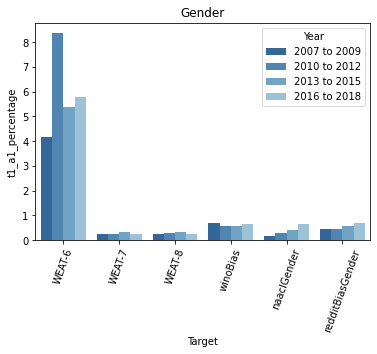

In [124]:
sns.set_palette(sns.color_palette("Blues_r"))

sns_plot_gender = sns.barplot(data = time_evaluation_gender,
                        x = 'Target', 
                        y = 't1_a1_percentage',
                        hue = 'Year',
                    alpha=0.9).set_title("Gender")

plt.xticks(rotation=70)

plt.savefig('gender_timeEval_t1_a1_perc.jpg', bbox_inches = "tight")

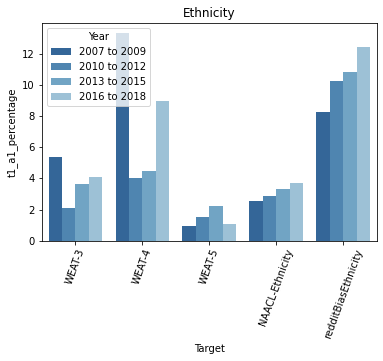

In [135]:
sns.set_palette(sns.color_palette("Blues_r"))

sns_plot_ethnicity = sns.barplot(data = time_evaluation_ethnicity,
                        x = 'Target', 
                        y = 't1_a1_percentage',
                        hue = 'Year',
                    alpha=0.9).set_title("Ethnicity")

plt.xticks(rotation=70)

plt.savefig('ethnicity_timeEval_t1_a1_perc.jpg', bbox_inches = "tight")

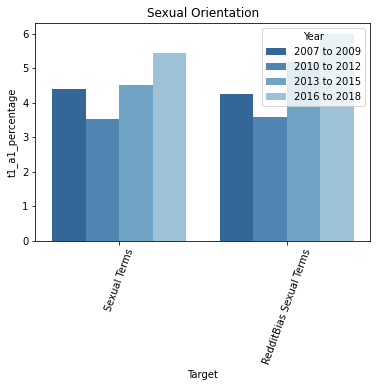

In [126]:
sns.set_palette(sns.color_palette("Blues_r"))

sns_plot_ethnicity = sns.barplot(data = time_evaluation_sexual,
                        x = 'Target', 
                        y = 't1_a1_percentage',
                        hue = 'Year',
                    alpha=0.9).set_title("Sexual Orientation")

plt.xticks(rotation=70)

plt.savefig('sexOr_timeEval_t1_a1_perc.jpg', bbox_inches = "tight")

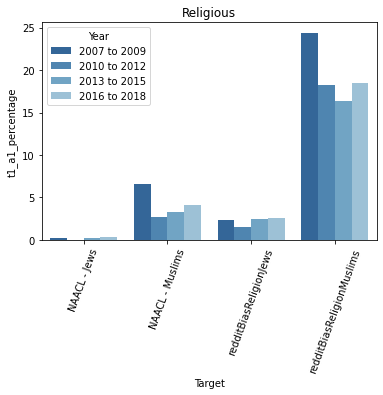

In [127]:
sns.set_palette(sns.color_palette("Blues_r"))

sns_plot_ethnicity = sns.barplot(data = time_evaluation_religious,
                        x = 'Target', 
                        y = 't1_a1_percentage',
                        hue = 'Year',
                    alpha=0.9).set_title("Religious")

plt.xticks(rotation=70)

plt.savefig('religious_timeEval_t1_a1_perc.jpg', bbox_inches = "tight")

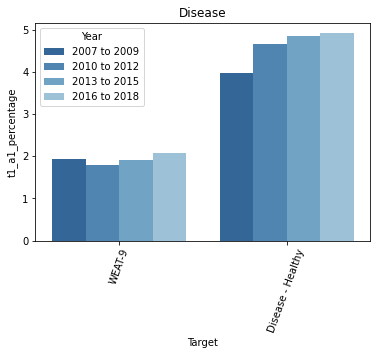

In [128]:
sns.set_palette(sns.color_palette("Blues_r"))

sns_plot_ethnicity = sns.barplot(data = time_evaluation_disease,
                        x = 'Target', 
                        y = 't1_a1_percentage',
                        hue = 'Year',
                    alpha=0.9).set_title("Disease")

plt.xticks(rotation=70)

plt.savefig('disease_timeEval_t1_a1_perc.jpg', bbox_inches = "tight")

In [141]:
list_of_dfs = [time_evaluation_gender, time_evaluation_ethnicity, time_evaluation_religious, 
               time_evaluation_sexual, time_evaluation_disease]

In [142]:
whole_frame = pd.concat(list_of_dfs)

In [144]:
whole_frame.groupby(by=["Target"]).sum()

,totalMinorityOccurrence,totalMajorityOccurrence,t1_a1_total,t1_a1_percentage,t1_a2_total,t1_a2_percentage,t2_a1_total,t2_a1_percentage,t2_a2_total,t2_a2_percentage,DS size,minorityPercentage,majorityPercentage
Target,,,,,,,,,,,,,
Disease - Healthy,99387.0,105662.0,4705.0,18.45,3900.0,15.16,3415.0,13.11,16648.0,61.92,495531,88.618304,95.860951
NAACL - Jews,26215.0,163667.0,65.0,0.88,117.0,1.88,314.0,0.76,891.0,2.17,495531,22.308392,143.215544
NAACL - Muslims,41163.0,163667.0,1527.0,16.73,780.0,7.00,759.0,1.82,911.0,2.21,495531,32.161720,143.215544
NAACL-Ethnicity,53671.0,189329.0,1798.0,16.14,433.0,4.19,2378.0,6.26,1387.0,3.73,626452,46.983707,165.954131
RedditBias Sexual Terms,68849.0,16337.0,3346.0,19.02,4394.0,24.32,467.0,11.18,973.0,23.80,495531,63.716290,15.456325
Sexual Terms,67216.0,16251.0,2982.0,17.86,4806.0,29.64,346.0,8.95,973.0,24.90,495531,62.229778,15.400283
WEAT-3,848.0,51540.0,31.0,15.22,33.0,16.88,2462.0,19.62,2563.0,20.06,495531,0.716665,46.000861
WEAT-4,1524.0,14673.0,94.0,39.86,82.0,28.61,801.0,27.53,1130.0,37.83,626452,1.151294,12.366435
WEAT-5,1524.0,14673.0,27.0,6.84,63.0,21.05,227.0,7.83,382.0,13.39,626452,1.151294,12.366435
